# Experiment 1
- Pre-trained model: BERT-based TAPE model => 12개의 encoder layers

- Fine-tuning rounds:
    - Round 1
        - 말단 10개의 encoder와 classifier를 Dash, VDJdb, McPAS 데이터를 사용하여 fine-tuning
        - 150 epochs with early stopping until 15 epochs
        - Adam optimizer with lr: 1e-4
    - Round 2
        - 말단 6개 encoder와 classifier를 IEDB SARS-2 데이터를 사용하여 fine-tuning
        - 100 epochs with early stopping until 10 epochs
        - Adam optimizer with lr: 1e-5
        
- Model evaluation
    - COVID-19 S-protein269-277(YLQPRTFLL) with the epitope-specific TCRβs from recent two studies
    - 352 TCRbeta from Shomuradova et al, 415 TCRbeta from ImmuneCODE
    - Attention 분석을 통해 TCR CDR3beta와 에피토프 펩타이드 서열의 모티프를 식별한다.
   

## Global configurations

In [1]:
import logging
import logging.config
import os
import sys
import warnings
from enum import auto
import pandas as pd
import numpy as np
from IPython.core.display import display

rootdir = '/home/hym/trunk/TCRBert'
workdir = '%s/notebook' % rootdir
datadir = '%s/data' % rootdir
srcdir = '%s/tcrbert' % rootdir
outdir = '%s/output' % rootdir

os.chdir(workdir)

sys.path.append(rootdir)
sys.path.append(srcdir)

from tcrbert.exp import Experiment
from tcrbert.predlistener import PredResultRecoder


# Display
pd.set_option('display.max.rows', 2000)
pd.set_option('display.max.columns', 2000)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('tcrbert')
logger.setLevel(logging.INFO)

# Target experiment
exp_key = 'exp1'
experiment = Experiment.from_key(exp_key)

exp_conf = experiment.exp_conf

display(exp_conf)

2021-10-01 23:58:27 [INFO]: Loaded exp_conf: {'title': 'exp1', 'description': 'Dash, VDJdb, McPAS 데이터로 말단 10개의 encoder와 classifier 학습=>IEDB SARS-2 데이터로 말단 6개 encoder와 classifier 학습', 'paper': 'exp1', 'model_config': '../config/bert-base/', 'train': {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 1e-05}, 'train_bert_encoders

{'title': 'exp1',
 'description': 'Dash, VDJdb, McPAS 데이터로 말단 10개의 encoder와 classifier 학습=>IEDB SARS-2 데이터로 말단 6개 encoder와 classifier 학습',
 'paper': 'exp1',
 'model_config': '../config/bert-base/',
 'train': {'pretrained_model': {'type': 'tape',
   'location': '../config/bert-base/'},
  'data_parallel': False,
  'rounds': [{'data': 'dash_vdjdb_mcpas',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 150,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'type': 'adam', 'lr': 0.0001},
    'train_bert_encoders': [-10, None],
    'early_stopper': {'monitor': 'accuracy', 'patience': 15},
    'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk',
     'monitor': 'accuracy',
     'save_best_only': True,
     'period': 1},
    'result': '../output/exp1/train.{round}.result.json'},
   {'data': 'iedb_sars2',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 100,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'t

## Exploring fine-tuning datasets

### Dash + VDJdb + McPAS

In [6]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN

train_ds = TCREpitopeSentenceDataset.from_key('dash_vdjdb_mcpas')
train_df = train_ds.df_enc

sent_encoder = train_ds.encoder

display(train_df.head(), train_df.shape)
tmp = train_df.epitope.value_counts()
display(tmp, tmp.shape)
display(train_df.label.value_counts())

display(train_df[train_ds.CN_SENTENCE].map(lambda x: ''.join(sent_encoder.to_tokens(x))))

np.count_nonzero(train_df[CN.epitope] == 'YLQPRTFLL')

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
GLCTLVAML_CASSLWTGSHEQYF,GLCTLVAML,BMLF,EBV,human,CASSLWTGSHEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSQSPGGEQYF,GLCTLVAML,BMLF,EBV,human,CASSQSPGGEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSLTTEQQFF,GLCTLVAML,BMLF,EBV,human,CASSLTTEQQFF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CSARDATGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDATGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."
GLCTLVAML_CSARDSTGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDSTGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."


(25138, 9)

LPRRSGAAGA      4284
GILGFVFTL       2560
GLCTLVAML       1858
NLVPMVATV       1370
CRVLCCYVL        870
SSLENFRAYV       840
TPRVTGGGAM       696
SSYRRPVGI        686
ELAGIGILTV       576
ASNENMETM        570
EAAGIGILTV       566
VTEHDTLLY        546
FRCPRRFCF        532
LLWNGPMAV        478
KRWIILGLNK       464
RAKFKQLL         440
RPHERNGFTVL      412
HGIRNASFI        402
LSLRNPILV        372
KAFSPEVIPMF      344
ATDALMTGY        306
CTPYDINQM        304
SFHSLHLLF        276
FLCMKALLL        272
TTPESANL         228
FPRPWLHGL        190
KLVALGINAV       188
EIYKRWII         188
YVLDHLIVV        184
FLKEKGGL         180
TPQDLNTML        150
IPSINVHHY        150
SSPPMFRV         148
TVYGFCLL         146
NLNCCSVPV        140
STPESANL         138
LPPIVAKEI        128
HPKVSSEVHI       126
YSEHPTFTSQY      126
GTSGSPIVNR       124
NEGVKAAW         124
TPGPGVRYPL       124
GPGHKARVL        112
IMNDMPIYM        110
GTSGSPIINR        96
KMVAVFYTT         94
MLNIPSINV         92
HSKKKCDEL    

(78,)

0    12569
1    12569
Name: label, dtype: int64

GLCTLVAML_CASSLWTGSHEQYF     <cls>GLCTLVAMLCASSLWTGSHEQYF<sep><pad><pad><pa...
GLCTLVAML_CASSQSPGGEQYF      <cls>GLCTLVAMLCASSQSPGGEQYF<sep><pad><pad><pad...
GLCTLVAML_CASSLTTEQQFF       <cls>GLCTLVAMLCASSLTTEQQFF<sep><pad><pad><pad>...
GLCTLVAML_CSARDATGNGYTF      <cls>GLCTLVAMLCSARDATGNGYTF<sep><pad><pad><pad...
GLCTLVAML_CSARDSTGNGYTF      <cls>GLCTLVAMLCSARDSTGNGYTF<sep><pad><pad><pad...
                                                   ...                        
YVLDHLIVV_CASHAGTLKEKLFF     <cls>YVLDHLIVVCASHAGTLKEKLFF<sep><pad><pad><pa...
YVLDHLIVV_CAISDETEAFF        <cls>YVLDHLIVVCAISDETEAFF<sep><pad><pad><pad><...
YVLDHLIVV_CASRPGQINQPQHF     <cls>YVLDHLIVVCASRPGQINQPQHF<sep><pad><pad><pa...
YVLDHLIVV_CSAFALSPSTDTQYF    <cls>YVLDHLIVVCSAFALSPSTDTQYF<sep><pad><pad><p...
YVLDHLIVV_CASSPGVTGEKLFF     <cls>YVLDHLIVVCASSPGVTGEKLFF<sep><pad><pad><pa...
Name: sentence, Length: 25138, dtype: object

0

### IEDB SARS-Cov-2

In [8]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN

train_ds = TCREpitopeSentenceDataset.from_key('iedb_sars2')
train_df = train_ds.df_enc

sent_encoder = train_ds.encoder

display(train_df.head(), train_df.shape)
tmp = train_df.epitope.value_counts()
display(tmp, tmp.shape)
display(train_df.label.value_counts())

display(train_df[train_ds.CN_SENTENCE].map(lambda x: ''.join(sent_encoder.to_tokens(x))))

np.count_nonzero(train_df[CN.epitope] == 'YLQPRTFLL')

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
FLPFFSNVTWFHAI_CASSIRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSSYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIGVYGYTF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIGVYGYTF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSAYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSSRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSSRSSYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSTRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSTRSAYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."


(98563, 9)

HTTDPSFLGRY        11586
SEHDYQIGGYTEKW      6848
FLNGSCGSV           5136
KLSYGIATV           4920
AELAKNVSLDNVL       3588
APKEIIFLEGETL       3572
LSPRWYFYYL          3502
KLPDDFTGCV          2638
VLPFNDGVYFASTEK     2593
VQELYSPIFLIV        2126
GMEVTPSGTWLTY       1990
LLLDDFVEII          1936
SELVIGAVIL          1800
RQLLFVVEV           1784
YEDFLEYHDVRVVL      1752
FLPRVFSAV           1734
KAYNVTQAF           1614
VLPPLLTDEMIAQYT     1348
TVLSFCAFAV          1226
WICLLQFAY           1180
TLIGDCATV           1138
NPLLYDANYFLCW       1096
YEQYIKWPWYI         1074
VLHSYFTSDYYQLY       970
RSVASQSIIAYTMSL      940
SNEKQEILGTVSWNL      902
YLNTLTLAV            864
FGEVFNATRFASVY       836
LEPLVDLPI            834
YFPLQSYGF            796
YYVGYLQPRTFLL        730
KPLEFGATSAAL         724
ALRKVPTDNYITTY       692
AYKTFPPTEPK          676
KLWAQCVQL            624
RNPANNAAIVL          622
FLPFFSNVTWFHAI       602
VYSTGSNVFQTR         572
NRDVDTDFVNEFYAY      570
SEVGPEHSLAEY         542


(145,)

1    49282
0    49281
Name: label, dtype: int64

FLPFFSNVTWFHAI_CASSIRSSYEQYF     <cls>FLPFFSNVTWFHAICASSIRSSYEQYF<sep><pad><pad...
FLPFFSNVTWFHAI_CASSIGVYGYTF      <cls>FLPFFSNVTWFHAICASSIGVYGYTF<sep><pad><pad>...
FLPFFSNVTWFHAI_CASSIRSAYEQYF     <cls>FLPFFSNVTWFHAICASSIRSAYEQYF<sep><pad><pad...
FLPFFSNVTWFHAI_CASSSRSSYEQYF     <cls>FLPFFSNVTWFHAICASSSRSSYEQYF<sep><pad><pad...
FLPFFSNVTWFHAI_CASSTRSAYEQYF     <cls>FLPFFSNVTWFHAICASSTRSAYEQYF<sep><pad><pad...
                                                       ...                        
YYVGYLQPRTFLL_CASSLGDGTEAFF      <cls>YYVGYLQPRTFLLCASSLGDGTEAFF<sep><pad><pad>...
YYVGYLQPRTFLL_CASSAGDSYEQYF      <cls>YYVGYLQPRTFLLCASSAGDSYEQYF<sep><pad><pad>...
YYVGYLQPRTFLL_CASSQDTYQETQYF     <cls>YYVGYLQPRTFLLCASSQDTYQETQYF<sep><pad><pad...
YYVGYLQPRTFLL_CASSGDRVGTDTQYF    <cls>YYVGYLQPRTFLLCASSGDRVGTDTQYF<sep><pad><pa...
YYVGYLQPRTFLL_CASSLDLAAGEQYF     <cls>YYVGYLQPRTFLLCASSLDLAAGEQYF<sep><pad><pad...
Name: sentence, Length: 98563, dtype: object

0

## Fine-tuning

In [9]:
experiment.train()

2021-10-02 00:05:45 [INFO]: ======================
2021-10-02 00:05:45 [INFO]: Begin train at 2021-10-02 00:05:45.449597
2021-10-02 00:05:45 [INFO]: Loading the TAPE pretrained model from ../config/bert-base/
2021-10-02 00:05:49 [INFO]: Start 2 train rounds of exp1 at 2021-10-02 00:05:45.449597
2021-10-02 00:05:49 [INFO]: train_conf: {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'type': 'adam', 'lr': 0.0001}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.{round}.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.{round}.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'm

2021-10-02 00:05:53 [INFO]: train.n_data: 20110, test.n_data: 5028
2021-10-02 00:05:53 [INFO]: optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
2021-10-02 00:05:53 [INFO]: evaluator: <tcrbert.model.BertTCREpitopeModel.PredictionEvaluator object at 0x7f2f0fc780d0>
2021-10-02 00:05:53 [INFO]: n_epochs: 150
2021-10-02 00:05:53 [INFO]: train.batch_size: 128
2021-10-02 00:05:53 [INFO]: test.batch_size: 128
2021-10-02 00:05:53 [INFO]: --------------------
2021-10-02 00:05:53 [INFO]: Begin epoch 0/150 at 2021-10-02 00:05:53.603579
2021-10-02 00:05:53 [INFO]: Begin training phase at epoch 0/150
2021-10-02 00:05:54 [INFO]: Begin 0/157 batch in train phase of 0/150 epoch
2021-10-02 00:05:55 [INFO]: End 0/157 batch in train phase of 0/150 epoch
2021-10-02 00:05:55 [INFO]: Begin 1/157 batch in train phase of 0/150 epoch
2021-10-02 00:05:56 [INFO]: End 1/157 batch in train phase of 0/150 epoch
2021-10-02 00:05:56 [INF

2021-10-02 00:06:56 [INFO]: Begin 50/157 batch in train phase of 0/150 epoch
2021-10-02 00:06:58 [INFO]: End 50/157 batch in train phase of 0/150 epoch
2021-10-02 00:06:58 [INFO]: Begin 51/157 batch in train phase of 0/150 epoch
2021-10-02 00:06:59 [INFO]: End 51/157 batch in train phase of 0/150 epoch
2021-10-02 00:06:59 [INFO]: Begin 52/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:01 [INFO]: End 52/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:01 [INFO]: Begin 53/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:02 [INFO]: End 53/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:02 [INFO]: Begin 54/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:04 [INFO]: End 54/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:04 [INFO]: Begin 55/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:05 [INFO]: End 55/157 batch in train phase of 0/150 epoch
2021-10-02 00:07:05 [INFO]: Begin 56/157 batch in train phase of 0/150 epoch
2021-10-02 

2021-10-02 00:08:19 [INFO]: Begin 104/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:21 [INFO]: End 104/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:21 [INFO]: Begin 105/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:22 [INFO]: End 105/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:22 [INFO]: Begin 106/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:24 [INFO]: End 106/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:24 [INFO]: Begin 107/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:25 [INFO]: End 107/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:25 [INFO]: Begin 108/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:27 [INFO]: End 108/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:27 [INFO]: Begin 109/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:28 [INFO]: End 109/157 batch in train phase of 0/150 epoch
2021-10-02 00:08:28 [INFO]: Begin 110/157 batch in train phase of 0/150 epoc

2021-10-02 00:09:42 [INFO]: End 157/157 batch in train phase of 0/150 epoch
2021-10-02 00:09:42 [INFO]: End training phase at epoch 0/150
2021-10-02 00:09:42 [INFO]: Begin validation phase at epoch 0/150
2021-10-02 00:09:43 [INFO]: Begin 0/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:44 [INFO]: End 0/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:44 [INFO]: Begin 1/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:45 [INFO]: End 1/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:45 [INFO]: Begin 2/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:46 [INFO]: End 2/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:46 [INFO]: Begin 3/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:46 [INFO]: End 3/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:46 [INFO]: Begin 4/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:47 [INFO]: End 4/39 batch in val phase of 0/150 epoch
2021-10-02 00:09:47 [INFO]: Begin 5/39 batch in val phase of 0/150 epoch
202

2021-10-02 00:10:30 [INFO]: Begin 8/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:31 [INFO]: End 8/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:31 [INFO]: Begin 9/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:33 [INFO]: End 9/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:33 [INFO]: Begin 10/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:34 [INFO]: End 10/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:34 [INFO]: Begin 11/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:35 [INFO]: End 11/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:35 [INFO]: Begin 12/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:36 [INFO]: End 12/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:36 [INFO]: Begin 13/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:38 [INFO]: End 13/157 batch in train phase of 1/150 epoch
2021-10-02 00:10:38 [INFO]: Begin 14/157 batch in train phase of 1/150 epoch
2021-10-02 00:1

2021-10-02 00:11:38 [INFO]: Begin 62/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:39 [INFO]: End 62/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:39 [INFO]: Begin 63/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:41 [INFO]: End 63/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:41 [INFO]: Begin 64/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:42 [INFO]: End 64/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:42 [INFO]: Begin 65/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:43 [INFO]: End 65/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:43 [INFO]: Begin 66/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:44 [INFO]: End 66/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:44 [INFO]: Begin 67/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:46 [INFO]: End 67/157 batch in train phase of 1/150 epoch
2021-10-02 00:11:46 [INFO]: Begin 68/157 batch in train phase of 1/150 epoch
2021-10-02 

2021-10-02 00:12:46 [INFO]: Begin 116/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:47 [INFO]: End 116/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:47 [INFO]: Begin 117/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:49 [INFO]: End 117/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:49 [INFO]: Begin 118/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:50 [INFO]: End 118/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:50 [INFO]: Begin 119/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:51 [INFO]: End 119/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:51 [INFO]: Begin 120/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:52 [INFO]: End 120/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:52 [INFO]: Begin 121/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:54 [INFO]: End 121/157 batch in train phase of 1/150 epoch
2021-10-02 00:12:54 [INFO]: Begin 122/157 batch in train phase of 1/150 epoc

2021-10-02 00:13:50 [INFO]: End 11/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:50 [INFO]: Begin 12/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:51 [INFO]: End 12/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:51 [INFO]: Begin 13/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:52 [INFO]: End 13/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:52 [INFO]: Begin 14/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:53 [INFO]: End 14/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:53 [INFO]: Begin 15/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:54 [INFO]: End 15/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:54 [INFO]: Begin 16/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:55 [INFO]: End 16/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:55 [INFO]: Begin 17/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:55 [INFO]: End 17/39 batch in val phase of 1/150 epoch
2021-10-02 00:13:55 [INFO]: Begin 18/39 batch in val

2021-10-02 00:14:42 [INFO]: Begin 20/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:43 [INFO]: End 20/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:43 [INFO]: Begin 21/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:44 [INFO]: End 21/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:44 [INFO]: Begin 22/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:46 [INFO]: End 22/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:46 [INFO]: Begin 23/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:47 [INFO]: End 23/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:47 [INFO]: Begin 24/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:48 [INFO]: End 24/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:48 [INFO]: Begin 25/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:49 [INFO]: End 25/157 batch in train phase of 2/150 epoch
2021-10-02 00:14:49 [INFO]: Begin 26/157 batch in train phase of 2/150 epoch
2021-10-02 

2021-10-02 00:15:49 [INFO]: Begin 74/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:50 [INFO]: End 74/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:50 [INFO]: Begin 75/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:52 [INFO]: End 75/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:52 [INFO]: Begin 76/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:53 [INFO]: End 76/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:53 [INFO]: Begin 77/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:54 [INFO]: End 77/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:54 [INFO]: Begin 78/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:55 [INFO]: End 78/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:55 [INFO]: Begin 79/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:57 [INFO]: End 79/157 batch in train phase of 2/150 epoch
2021-10-02 00:15:57 [INFO]: Begin 80/157 batch in train phase of 2/150 epoch
2021-10-02 

2021-10-02 00:16:56 [INFO]: Begin 128/157 batch in train phase of 2/150 epoch
2021-10-02 00:16:58 [INFO]: End 128/157 batch in train phase of 2/150 epoch
2021-10-02 00:16:58 [INFO]: Begin 129/157 batch in train phase of 2/150 epoch
2021-10-02 00:16:59 [INFO]: End 129/157 batch in train phase of 2/150 epoch
2021-10-02 00:16:59 [INFO]: Begin 130/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:00 [INFO]: End 130/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:00 [INFO]: Begin 131/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:01 [INFO]: End 131/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:01 [INFO]: Begin 132/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:03 [INFO]: End 132/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:03 [INFO]: Begin 133/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:04 [INFO]: End 133/157 batch in train phase of 2/150 epoch
2021-10-02 00:17:04 [INFO]: Begin 134/157 batch in train phase of 2/150 epoc

2021-10-02 00:17:56 [INFO]: Begin 24/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:57 [INFO]: End 24/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:57 [INFO]: Begin 25/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:58 [INFO]: End 25/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:58 [INFO]: Begin 26/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:59 [INFO]: End 26/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:59 [INFO]: Begin 27/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:59 [INFO]: End 27/39 batch in val phase of 2/150 epoch
2021-10-02 00:17:59 [INFO]: Begin 28/39 batch in val phase of 2/150 epoch
2021-10-02 00:18:00 [INFO]: End 28/39 batch in val phase of 2/150 epoch
2021-10-02 00:18:00 [INFO]: Begin 29/39 batch in val phase of 2/150 epoch
2021-10-02 00:18:01 [INFO]: End 29/39 batch in val phase of 2/150 epoch
2021-10-02 00:18:01 [INFO]: Begin 30/39 batch in val phase of 2/150 epoch
2021-10-02 00:18:02 [INFO]: End 30/39 batch in val

2021-10-02 00:18:52 [INFO]: Begin 32/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:53 [INFO]: End 32/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:53 [INFO]: Begin 33/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:54 [INFO]: End 33/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:54 [INFO]: Begin 34/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:55 [INFO]: End 34/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:55 [INFO]: Begin 35/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:57 [INFO]: End 35/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:57 [INFO]: Begin 36/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:58 [INFO]: End 36/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:58 [INFO]: Begin 37/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:59 [INFO]: End 37/157 batch in train phase of 3/150 epoch
2021-10-02 00:18:59 [INFO]: Begin 38/157 batch in train phase of 3/150 epoch
2021-10-02 

2021-10-02 00:20:00 [INFO]: Begin 86/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:01 [INFO]: End 86/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:01 [INFO]: Begin 87/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:02 [INFO]: End 87/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:02 [INFO]: Begin 88/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:03 [INFO]: End 88/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:03 [INFO]: Begin 89/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:05 [INFO]: End 89/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:05 [INFO]: Begin 90/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:06 [INFO]: End 90/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:06 [INFO]: Begin 91/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:07 [INFO]: End 91/157 batch in train phase of 3/150 epoch
2021-10-02 00:20:07 [INFO]: Begin 92/157 batch in train phase of 3/150 epoch
2021-10-02 

2021-10-02 00:21:07 [INFO]: End 139/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:07 [INFO]: Begin 140/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:08 [INFO]: End 140/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:08 [INFO]: Begin 141/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:09 [INFO]: End 141/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:09 [INFO]: Begin 142/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:11 [INFO]: End 142/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:11 [INFO]: Begin 143/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:12 [INFO]: End 143/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:12 [INFO]: Begin 144/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:13 [INFO]: End 144/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:13 [INFO]: Begin 145/157 batch in train phase of 3/150 epoch
2021-10-02 00:21:14 [INFO]: End 145/157 batch in train phase of 3/150 epoch


2021-10-02 00:22:03 [INFO]: Begin 36/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:04 [INFO]: End 36/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:04 [INFO]: Begin 37/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:05 [INFO]: End 37/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:05 [INFO]: Begin 38/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:06 [INFO]: End 38/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:06 [INFO]: Begin 39/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:07 [INFO]: End 39/39 batch in val phase of 3/150 epoch
2021-10-02 00:22:07 [INFO]: End validation phase at epoch 3/150
2021-10-02 00:22:07 [INFO]: [EvalScoreRecoder]: In epoch 3/150, loss train score: 0.5199430765041823, val score: 0.5461202681064605
2021-10-02 00:22:07 [INFO]: [EvalScoreRecoder]: In epoch 3/150, accuracy train score: 0.7205229995479204, val score: 0.6973958333333334
2021-10-02 00:22:07 [INFO]: [EarlyStopper]: In epoch 3/150, accuracy score: 0.697395

2021-10-02 00:23:04 [INFO]: End 43/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:04 [INFO]: Begin 44/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:05 [INFO]: End 44/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:05 [INFO]: Begin 45/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:06 [INFO]: End 45/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:06 [INFO]: Begin 46/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:07 [INFO]: End 46/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:07 [INFO]: Begin 47/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:09 [INFO]: End 47/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:09 [INFO]: Begin 48/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:10 [INFO]: End 48/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:10 [INFO]: Begin 49/157 batch in train phase of 4/150 epoch
2021-10-02 00:23:11 [INFO]: End 49/157 batch in train phase of 4/150 epoch
2021-10-02 00

2021-10-02 00:24:12 [INFO]: End 97/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:12 [INFO]: Begin 98/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:13 [INFO]: End 98/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:13 [INFO]: Begin 99/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:14 [INFO]: End 99/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:14 [INFO]: Begin 100/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:15 [INFO]: End 100/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:15 [INFO]: Begin 101/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:17 [INFO]: End 101/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:17 [INFO]: Begin 102/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:18 [INFO]: End 102/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:18 [INFO]: Begin 103/157 batch in train phase of 4/150 epoch
2021-10-02 00:24:19 [INFO]: End 103/157 batch in train phase of 4/150 epoch
2021-

2021-10-02 00:25:19 [INFO]: Begin 151/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:20 [INFO]: End 151/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:20 [INFO]: Begin 152/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:21 [INFO]: End 152/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:21 [INFO]: Begin 153/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:22 [INFO]: End 153/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:22 [INFO]: Begin 154/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:24 [INFO]: End 154/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:24 [INFO]: Begin 155/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:25 [INFO]: End 155/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:25 [INFO]: Begin 156/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:26 [INFO]: End 156/157 batch in train phase of 4/150 epoch
2021-10-02 00:25:26 [INFO]: Begin 157/157 batch in train phase of 4/150 epoc

2021-10-02 00:26:08 [INFO]: End 1/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:08 [INFO]: Begin 2/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:10 [INFO]: End 2/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:10 [INFO]: Begin 3/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:11 [INFO]: End 3/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:11 [INFO]: Begin 4/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:12 [INFO]: End 4/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:12 [INFO]: Begin 5/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:13 [INFO]: End 5/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:13 [INFO]: Begin 6/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:15 [INFO]: End 6/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:15 [INFO]: Begin 7/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:16 [INFO]: End 7/157 batch in train phase of 5/150 epoch
2021-10-02 00:26:16 [INFO]

2021-10-02 00:28:35 [INFO]: End 117/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:35 [INFO]: Begin 118/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:36 [INFO]: End 118/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:36 [INFO]: Begin 119/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:37 [INFO]: End 119/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:37 [INFO]: Begin 120/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:38 [INFO]: End 120/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:38 [INFO]: Begin 121/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:40 [INFO]: End 121/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:40 [INFO]: Begin 122/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:41 [INFO]: End 122/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:41 [INFO]: Begin 123/157 batch in train phase of 5/150 epoch
2021-10-02 00:28:42 [INFO]: End 123/157 batch in train phase of 5/150 epoch


2021-10-02 00:29:37 [INFO]: Begin 13/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:38 [INFO]: End 13/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:38 [INFO]: Begin 14/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:39 [INFO]: End 14/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:39 [INFO]: Begin 15/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:40 [INFO]: End 15/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:40 [INFO]: Begin 16/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:41 [INFO]: End 16/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:41 [INFO]: Begin 17/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:42 [INFO]: End 17/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:42 [INFO]: Begin 18/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:42 [INFO]: End 18/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:42 [INFO]: Begin 19/39 batch in val phase of 5/150 epoch
2021-10-02 00:29:43 [INFO]: End 19/39 batch in val

2021-10-02 00:30:30 [INFO]: Begin 22/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:32 [INFO]: End 22/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:32 [INFO]: Begin 23/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:33 [INFO]: End 23/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:33 [INFO]: Begin 24/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:34 [INFO]: End 24/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:34 [INFO]: Begin 25/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:35 [INFO]: End 25/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:35 [INFO]: Begin 26/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:37 [INFO]: End 26/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:37 [INFO]: Begin 27/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:38 [INFO]: End 27/157 batch in train phase of 6/150 epoch
2021-10-02 00:30:38 [INFO]: Begin 28/157 batch in train phase of 6/150 epoch
2021-10-02 

2021-10-02 00:31:39 [INFO]: Begin 76/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:40 [INFO]: End 76/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:40 [INFO]: Begin 77/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:41 [INFO]: End 77/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:41 [INFO]: Begin 78/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:42 [INFO]: End 78/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:42 [INFO]: Begin 79/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:44 [INFO]: End 79/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:44 [INFO]: Begin 80/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:45 [INFO]: End 80/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:45 [INFO]: Begin 81/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:46 [INFO]: End 81/157 batch in train phase of 6/150 epoch
2021-10-02 00:31:46 [INFO]: Begin 82/157 batch in train phase of 6/150 epoch
2021-10-02 

2021-10-02 00:32:47 [INFO]: Begin 130/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:48 [INFO]: End 130/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:48 [INFO]: Begin 131/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:49 [INFO]: End 131/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:49 [INFO]: Begin 132/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:51 [INFO]: End 132/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:51 [INFO]: Begin 133/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:52 [INFO]: End 133/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:52 [INFO]: Begin 134/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:53 [INFO]: End 134/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:53 [INFO]: Begin 135/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:55 [INFO]: End 135/157 batch in train phase of 6/150 epoch
2021-10-02 00:32:55 [INFO]: Begin 136/157 batch in train phase of 6/150 epoc

2021-10-02 00:33:47 [INFO]: Begin 26/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:48 [INFO]: End 26/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:48 [INFO]: Begin 27/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:49 [INFO]: End 27/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:49 [INFO]: Begin 28/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:50 [INFO]: End 28/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:50 [INFO]: Begin 29/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:51 [INFO]: End 29/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:51 [INFO]: Begin 30/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:52 [INFO]: End 30/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:52 [INFO]: Begin 31/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:53 [INFO]: End 31/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:53 [INFO]: Begin 32/39 batch in val phase of 6/150 epoch
2021-10-02 00:33:54 [INFO]: End 32/39 batch in val

2021-10-02 00:34:45 [INFO]: End 34/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:45 [INFO]: Begin 35/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:46 [INFO]: End 35/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:46 [INFO]: Begin 36/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:48 [INFO]: End 36/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:48 [INFO]: Begin 37/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:49 [INFO]: End 37/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:49 [INFO]: Begin 38/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:50 [INFO]: End 38/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:50 [INFO]: Begin 39/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:51 [INFO]: End 39/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:51 [INFO]: Begin 40/157 batch in train phase of 7/150 epoch
2021-10-02 00:34:53 [INFO]: End 40/157 batch in train phase of 7/150 epoch
2021-10-02 00

2021-10-02 00:35:54 [INFO]: End 88/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:54 [INFO]: Begin 89/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:55 [INFO]: End 89/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:55 [INFO]: Begin 90/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:56 [INFO]: End 90/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:56 [INFO]: Begin 91/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:57 [INFO]: End 91/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:57 [INFO]: Begin 92/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:59 [INFO]: End 92/157 batch in train phase of 7/150 epoch
2021-10-02 00:35:59 [INFO]: Begin 93/157 batch in train phase of 7/150 epoch
2021-10-02 00:36:00 [INFO]: End 93/157 batch in train phase of 7/150 epoch
2021-10-02 00:36:00 [INFO]: Begin 94/157 batch in train phase of 7/150 epoch
2021-10-02 00:36:01 [INFO]: End 94/157 batch in train phase of 7/150 epoch
2021-10-02 00

2021-10-02 00:37:01 [INFO]: Begin 142/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:02 [INFO]: End 142/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:02 [INFO]: Begin 143/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:03 [INFO]: End 143/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:03 [INFO]: Begin 144/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:05 [INFO]: End 144/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:05 [INFO]: Begin 145/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:06 [INFO]: End 145/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:06 [INFO]: Begin 146/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:07 [INFO]: End 146/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:07 [INFO]: Begin 147/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:08 [INFO]: End 147/157 batch in train phase of 7/150 epoch
2021-10-02 00:37:08 [INFO]: Begin 148/157 batch in train phase of 7/150 epoc

2021-10-02 00:37:57 [INFO]: End 38/39 batch in val phase of 7/150 epoch
2021-10-02 00:37:57 [INFO]: Begin 39/39 batch in val phase of 7/150 epoch
2021-10-02 00:37:57 [INFO]: End 39/39 batch in val phase of 7/150 epoch
2021-10-02 00:37:58 [INFO]: End validation phase at epoch 7/150
2021-10-02 00:37:58 [INFO]: [EvalScoreRecoder]: In epoch 7/150, loss train score: 0.31512537364010945, val score: 0.6728348210453987
2021-10-02 00:37:58 [INFO]: [EvalScoreRecoder]: In epoch 7/150, accuracy train score: 0.8590783227848101, val score: 0.7246310763888889
2021-10-02 00:37:58 [INFO]: [EarlyStopper]: In epoch 7/150, accuracy score: 0.7246310763888889, best accuracy score: 0.706640625;update best score to 0.7246310763888889
2021-10-02 00:37:58 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 7: accuracy improved from 0.706640625 to 0.7246310763888889, saving model to ../output/exp1/train.0.model_7.chk
2021-10-02 00:37:58 [INFO]: End epoch 7/150 at 2021-10-02 00:37:58.338709, elapsed: 0:03:57.775304
20

2021-10-02 00:38:58 [INFO]: Begin 46/157 batch in train phase of 8/150 epoch
2021-10-02 00:38:59 [INFO]: End 46/157 batch in train phase of 8/150 epoch
2021-10-02 00:38:59 [INFO]: Begin 47/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:00 [INFO]: End 47/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:00 [INFO]: Begin 48/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:01 [INFO]: End 48/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:01 [INFO]: Begin 49/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:03 [INFO]: End 49/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:03 [INFO]: Begin 50/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:04 [INFO]: End 50/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:04 [INFO]: Begin 51/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:05 [INFO]: End 51/157 batch in train phase of 8/150 epoch
2021-10-02 00:39:05 [INFO]: Begin 52/157 batch in train phase of 8/150 epoch
2021-10-02 

2021-10-02 00:40:06 [INFO]: Begin 100/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:07 [INFO]: End 100/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:07 [INFO]: Begin 101/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:08 [INFO]: End 101/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:08 [INFO]: Begin 102/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:09 [INFO]: End 102/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:09 [INFO]: Begin 103/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:11 [INFO]: End 103/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:11 [INFO]: Begin 104/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:12 [INFO]: End 104/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:12 [INFO]: Begin 105/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:13 [INFO]: End 105/157 batch in train phase of 8/150 epoch
2021-10-02 00:40:13 [INFO]: Begin 106/157 batch in train phase of 8/150 epoc

2021-10-02 00:41:14 [INFO]: End 153/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:14 [INFO]: Begin 154/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:15 [INFO]: End 154/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:15 [INFO]: Begin 155/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:16 [INFO]: End 155/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:16 [INFO]: Begin 156/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:18 [INFO]: End 156/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:18 [INFO]: Begin 157/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:18 [INFO]: End 157/157 batch in train phase of 8/150 epoch
2021-10-02 00:41:19 [INFO]: End training phase at epoch 8/150
2021-10-02 00:41:19 [INFO]: Begin validation phase at epoch 8/150
2021-10-02 00:41:19 [INFO]: Begin 0/39 batch in val phase of 8/150 epoch
2021-10-02 00:41:20 [INFO]: End 0/39 batch in val phase of 8/150 epoch
2021-10-02 00:41:20 [INFO]: Begin 1/

2021-10-02 00:42:02 [INFO]: End 3/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:02 [INFO]: Begin 4/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:03 [INFO]: End 4/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:03 [INFO]: Begin 5/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:05 [INFO]: End 5/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:05 [INFO]: Begin 6/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:06 [INFO]: End 6/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:06 [INFO]: Begin 7/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:07 [INFO]: End 7/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:07 [INFO]: Begin 8/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:08 [INFO]: End 8/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:08 [INFO]: Begin 9/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:10 [INFO]: End 9/157 batch in train phase of 9/150 epoch
2021-10-02 00:42:10 [INFO]

2021-10-02 00:43:10 [INFO]: End 57/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:10 [INFO]: Begin 58/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:12 [INFO]: End 58/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:12 [INFO]: Begin 59/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:13 [INFO]: End 59/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:13 [INFO]: Begin 60/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:14 [INFO]: End 60/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:14 [INFO]: Begin 61/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:15 [INFO]: End 61/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:15 [INFO]: Begin 62/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:16 [INFO]: End 62/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:17 [INFO]: Begin 63/157 batch in train phase of 9/150 epoch
2021-10-02 00:43:18 [INFO]: End 63/157 batch in train phase of 9/150 epoch
2021-10-02 00

2021-10-02 00:44:19 [INFO]: End 111/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:19 [INFO]: Begin 112/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:20 [INFO]: End 112/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:20 [INFO]: Begin 113/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:21 [INFO]: End 113/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:21 [INFO]: Begin 114/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:22 [INFO]: End 114/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:22 [INFO]: Begin 115/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:24 [INFO]: End 115/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:24 [INFO]: Begin 116/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:25 [INFO]: End 116/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:25 [INFO]: Begin 117/157 batch in train phase of 9/150 epoch
2021-10-02 00:44:26 [INFO]: End 117/157 batch in train phase of 9/150 epoch


2021-10-02 00:45:24 [INFO]: End 6/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:24 [INFO]: Begin 7/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:25 [INFO]: End 7/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:25 [INFO]: Begin 8/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:25 [INFO]: End 8/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:25 [INFO]: Begin 9/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:26 [INFO]: End 9/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:26 [INFO]: Begin 10/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:27 [INFO]: End 10/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:27 [INFO]: Begin 11/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:28 [INFO]: End 11/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:28 [INFO]: Begin 12/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:29 [INFO]: End 12/39 batch in val phase of 9/150 epoch
2021-10-02 00:45:29 [INFO]: Begin 13/39 batch in val phase 

2021-10-02 00:46:14 [INFO]: Begin 15/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:16 [INFO]: End 15/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:16 [INFO]: Begin 16/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:17 [INFO]: End 16/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:17 [INFO]: Begin 17/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:18 [INFO]: End 17/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:18 [INFO]: Begin 18/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:19 [INFO]: End 18/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:19 [INFO]: Begin 19/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:21 [INFO]: End 19/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:21 [INFO]: Begin 20/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:22 [INFO]: End 20/157 batch in train phase of 10/150 epoch
2021-10-02 00:46:22 [INFO]: Begin 21/157 batch in train phase of 10/150 epoc

2021-10-02 00:47:27 [INFO]: End 68/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:27 [INFO]: Begin 69/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:28 [INFO]: End 69/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:28 [INFO]: Begin 70/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:30 [INFO]: End 70/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:30 [INFO]: Begin 71/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:31 [INFO]: End 71/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:31 [INFO]: Begin 72/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:32 [INFO]: End 72/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:32 [INFO]: Begin 73/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:33 [INFO]: End 73/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:33 [INFO]: Begin 74/157 batch in train phase of 10/150 epoch
2021-10-02 00:47:35 [INFO]: End 74/157 batch in train phase of 10/150 epoch


2021-10-02 00:48:34 [INFO]: End 121/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:34 [INFO]: Begin 122/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:35 [INFO]: End 122/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:35 [INFO]: Begin 123/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:37 [INFO]: End 123/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:37 [INFO]: Begin 124/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:38 [INFO]: End 124/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:38 [INFO]: Begin 125/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:39 [INFO]: End 125/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:39 [INFO]: Begin 126/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:40 [INFO]: End 126/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:40 [INFO]: Begin 127/157 batch in train phase of 10/150 epoch
2021-10-02 00:48:42 [INFO]: End 127/157 batch in train phase of 

2021-10-02 00:49:35 [INFO]: End 16/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:35 [INFO]: Begin 17/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:36 [INFO]: End 17/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:36 [INFO]: Begin 18/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:37 [INFO]: End 18/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:37 [INFO]: Begin 19/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:38 [INFO]: End 19/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:38 [INFO]: Begin 20/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:39 [INFO]: End 20/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:39 [INFO]: Begin 21/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:40 [INFO]: End 21/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:40 [INFO]: Begin 22/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:41 [INFO]: End 22/39 batch in val phase of 10/150 epoch
2021-10-02 00:49:41 [INFO]: Begin 23/39

2021-10-02 00:50:29 [INFO]: End 24/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:29 [INFO]: Begin 25/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:30 [INFO]: End 25/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:30 [INFO]: Begin 26/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:31 [INFO]: End 26/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:31 [INFO]: Begin 27/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:33 [INFO]: End 27/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:33 [INFO]: Begin 28/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:34 [INFO]: End 28/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:34 [INFO]: Begin 29/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:35 [INFO]: End 29/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:35 [INFO]: Begin 30/157 batch in train phase of 11/150 epoch
2021-10-02 00:50:36 [INFO]: End 30/157 batch in train phase of 11/150 epoch


2021-10-02 00:51:36 [INFO]: Begin 78/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:37 [INFO]: End 78/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:37 [INFO]: Begin 79/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:38 [INFO]: End 79/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:38 [INFO]: Begin 80/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:40 [INFO]: End 80/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:40 [INFO]: Begin 81/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:41 [INFO]: End 81/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:41 [INFO]: Begin 82/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:42 [INFO]: End 82/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:42 [INFO]: Begin 83/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:43 [INFO]: End 83/157 batch in train phase of 11/150 epoch
2021-10-02 00:51:43 [INFO]: Begin 84/157 batch in train phase of 11/150 epoc

2021-10-02 00:52:42 [INFO]: Begin 131/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:43 [INFO]: End 131/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:43 [INFO]: Begin 132/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:45 [INFO]: End 132/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:45 [INFO]: Begin 133/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:46 [INFO]: End 133/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:46 [INFO]: Begin 134/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:47 [INFO]: End 134/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:47 [INFO]: Begin 135/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:48 [INFO]: End 135/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:48 [INFO]: Begin 136/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:50 [INFO]: End 136/157 batch in train phase of 11/150 epoch
2021-10-02 00:52:50 [INFO]: Begin 137/157 batch in train phase o

2021-10-02 00:53:42 [INFO]: End 26/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:42 [INFO]: Begin 27/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:43 [INFO]: End 27/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:43 [INFO]: Begin 28/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:44 [INFO]: End 28/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:44 [INFO]: Begin 29/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:45 [INFO]: End 29/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:45 [INFO]: Begin 30/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:46 [INFO]: End 30/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:46 [INFO]: Begin 31/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:47 [INFO]: End 31/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:47 [INFO]: Begin 32/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:48 [INFO]: End 32/39 batch in val phase of 11/150 epoch
2021-10-02 00:53:48 [INFO]: Begin 33/39

2021-10-02 00:54:38 [INFO]: Begin 34/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:39 [INFO]: End 34/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:39 [INFO]: Begin 35/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:41 [INFO]: End 35/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:41 [INFO]: Begin 36/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:42 [INFO]: End 36/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:42 [INFO]: Begin 37/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:43 [INFO]: End 37/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:43 [INFO]: Begin 38/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:44 [INFO]: End 38/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:44 [INFO]: Begin 39/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:46 [INFO]: End 39/157 batch in train phase of 12/150 epoch
2021-10-02 00:54:46 [INFO]: Begin 40/157 batch in train phase of 12/150 epoc

2021-10-02 00:55:45 [INFO]: End 87/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:45 [INFO]: Begin 88/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:47 [INFO]: End 88/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:47 [INFO]: Begin 89/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:48 [INFO]: End 89/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:48 [INFO]: Begin 90/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:49 [INFO]: End 90/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:49 [INFO]: Begin 91/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:50 [INFO]: End 91/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:50 [INFO]: Begin 92/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:52 [INFO]: End 92/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:52 [INFO]: Begin 93/157 batch in train phase of 12/150 epoch
2021-10-02 00:55:53 [INFO]: End 93/157 batch in train phase of 12/150 epoch


2021-10-02 00:56:52 [INFO]: End 140/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:52 [INFO]: Begin 141/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:53 [INFO]: End 141/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:53 [INFO]: Begin 142/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:55 [INFO]: End 142/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:55 [INFO]: Begin 143/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:56 [INFO]: End 143/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:56 [INFO]: Begin 144/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:57 [INFO]: End 144/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:57 [INFO]: Begin 145/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:58 [INFO]: End 145/157 batch in train phase of 12/150 epoch
2021-10-02 00:56:58 [INFO]: Begin 146/157 batch in train phase of 12/150 epoch
2021-10-02 00:57:00 [INFO]: End 146/157 batch in train phase of 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-10-02 00:57:25 [INFO]: End 11/39 batch in val phase of 12/150 epoch
2021-10-02 00:57:25 [INFO]: Begin 12/39 batch in val phase of 12/150 epoch
2021-10-02 00:58:58 [INFO]: End 51/157 batch in train phase of 13/150 epoch
2021-10-02 00:58:58 [INFO]: Begin 52/157 batch in train phase of 13/150 epoch
2021-10-02 00:58:59 [INFO]: End 52/157 batch in train phase of 13/150 epoch
2021-10-02 00:58:59 [INFO]: Begin 53/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:00 [INFO]: End 53/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:00 [INFO]: Begin 54/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:01 [INFO]: End 54/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:01 [INFO]: Begin 55/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:03 [INFO]: End 55/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:03 [INFO]: Begin 56/157 batch in train phase of 13/150 epoch
2021-10-02 00:59:04 [INFO]: End 56/157 batch in train phase of 13/150 epoch
2021-1

2021-10-02 01:00:03 [INFO]: Begin 104/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:04 [INFO]: End 104/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:04 [INFO]: Begin 105/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:06 [INFO]: End 105/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:06 [INFO]: Begin 106/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:07 [INFO]: End 106/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:07 [INFO]: Begin 107/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:08 [INFO]: End 107/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:08 [INFO]: Begin 108/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:09 [INFO]: End 108/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:09 [INFO]: Begin 109/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:11 [INFO]: End 109/157 batch in train phase of 13/150 epoch
2021-10-02 01:00:11 [INFO]: Begin 110/157 batch in train phase o

2021-10-02 01:01:10 [INFO]: Begin 157/157 batch in train phase of 13/150 epoch
2021-10-02 01:01:11 [INFO]: End 157/157 batch in train phase of 13/150 epoch
2021-10-02 01:01:11 [INFO]: End training phase at epoch 13/150
2021-10-02 01:01:11 [INFO]: Begin validation phase at epoch 13/150
2021-10-02 01:01:11 [INFO]: Begin 0/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:12 [INFO]: End 0/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:12 [INFO]: Begin 1/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:13 [INFO]: End 1/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:13 [INFO]: Begin 2/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:14 [INFO]: End 2/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:14 [INFO]: Begin 3/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:15 [INFO]: End 3/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:15 [INFO]: Begin 4/39 batch in val phase of 13/150 epoch
2021-10-02 01:01:16 [INFO]: End 4/39 batch in val phase 

2021-10-02 01:01:58 [INFO]: Begin 7/157 batch in train phase of 14/150 epoch
2021-10-02 01:01:59 [INFO]: End 7/157 batch in train phase of 14/150 epoch
2021-10-02 01:01:59 [INFO]: Begin 8/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:01 [INFO]: End 8/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:01 [INFO]: Begin 9/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:02 [INFO]: End 9/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:02 [INFO]: Begin 10/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:03 [INFO]: End 10/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:03 [INFO]: Begin 11/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:04 [INFO]: End 11/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:04 [INFO]: Begin 12/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:06 [INFO]: End 12/157 batch in train phase of 14/150 epoch
2021-10-02 01:02:06 [INFO]: Begin 13/157 batch in train phase of 14/150 epoch
2021

2021-10-02 01:03:05 [INFO]: End 60/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:05 [INFO]: Begin 61/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:07 [INFO]: End 61/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:07 [INFO]: Begin 62/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:08 [INFO]: End 62/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:08 [INFO]: Begin 63/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:09 [INFO]: End 63/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:09 [INFO]: Begin 64/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:11 [INFO]: End 64/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:11 [INFO]: Begin 65/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:12 [INFO]: End 65/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:12 [INFO]: Begin 66/157 batch in train phase of 14/150 epoch
2021-10-02 01:03:13 [INFO]: End 66/157 batch in train phase of 14/150 epoch


2021-10-02 01:04:13 [INFO]: Begin 114/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:14 [INFO]: End 114/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:14 [INFO]: Begin 115/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:15 [INFO]: End 115/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:15 [INFO]: Begin 116/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:16 [INFO]: End 116/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:16 [INFO]: Begin 117/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:18 [INFO]: End 117/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:18 [INFO]: Begin 118/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:19 [INFO]: End 118/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:19 [INFO]: Begin 119/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:20 [INFO]: End 119/157 batch in train phase of 14/150 epoch
2021-10-02 01:04:20 [INFO]: Begin 120/157 batch in train phase o

2021-10-02 01:05:17 [INFO]: End 8/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:17 [INFO]: Begin 9/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:18 [INFO]: End 9/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:18 [INFO]: Begin 10/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:19 [INFO]: End 10/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:19 [INFO]: Begin 11/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:20 [INFO]: End 11/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:20 [INFO]: Begin 12/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:21 [INFO]: End 12/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:21 [INFO]: Begin 13/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:22 [INFO]: End 13/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:22 [INFO]: Begin 14/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:23 [INFO]: End 14/39 batch in val phase of 14/150 epoch
2021-10-02 01:05:23 [INFO]: Begin 15/39 ba

2021-10-02 01:06:08 [INFO]: End 16/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:08 [INFO]: Begin 17/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:09 [INFO]: End 17/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:09 [INFO]: Begin 18/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:10 [INFO]: End 18/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:10 [INFO]: Begin 19/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:12 [INFO]: End 19/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:12 [INFO]: Begin 20/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:13 [INFO]: End 20/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:13 [INFO]: Begin 21/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:14 [INFO]: End 21/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:14 [INFO]: Begin 22/157 batch in train phase of 15/150 epoch
2021-10-02 01:06:15 [INFO]: End 22/157 batch in train phase of 15/150 epoch


2021-10-02 01:07:14 [INFO]: Begin 70/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:16 [INFO]: End 70/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:16 [INFO]: Begin 71/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:17 [INFO]: End 71/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:17 [INFO]: Begin 72/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:18 [INFO]: End 72/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:18 [INFO]: Begin 73/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:20 [INFO]: End 73/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:20 [INFO]: Begin 74/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:21 [INFO]: End 74/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:21 [INFO]: Begin 75/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:22 [INFO]: End 75/157 batch in train phase of 15/150 epoch
2021-10-02 01:07:22 [INFO]: Begin 76/157 batch in train phase of 15/150 epoc

2021-10-02 01:08:22 [INFO]: Begin 123/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:23 [INFO]: End 123/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:23 [INFO]: Begin 124/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:24 [INFO]: End 124/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:24 [INFO]: Begin 125/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:25 [INFO]: End 125/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:25 [INFO]: Begin 126/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:27 [INFO]: End 126/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:27 [INFO]: Begin 127/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:28 [INFO]: End 127/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:28 [INFO]: Begin 128/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:29 [INFO]: End 128/157 batch in train phase of 15/150 epoch
2021-10-02 01:08:29 [INFO]: Begin 129/157 batch in train phase o

2021-10-02 01:09:23 [INFO]: Begin 18/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:24 [INFO]: End 18/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:24 [INFO]: Begin 19/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:25 [INFO]: End 19/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:25 [INFO]: Begin 20/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:26 [INFO]: End 20/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:26 [INFO]: Begin 21/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:27 [INFO]: End 21/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:27 [INFO]: Begin 22/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:27 [INFO]: End 22/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:27 [INFO]: Begin 23/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:28 [INFO]: End 23/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:28 [INFO]: Begin 24/39 batch in val phase of 15/150 epoch
2021-10-02 01:09:29 [INFO]: End 24/39

2021-10-02 01:10:17 [INFO]: End 25/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:17 [INFO]: Begin 26/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:18 [INFO]: End 26/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:18 [INFO]: Begin 27/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:19 [INFO]: End 27/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:19 [INFO]: Begin 28/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:20 [INFO]: End 28/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:20 [INFO]: Begin 29/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:22 [INFO]: End 29/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:22 [INFO]: Begin 30/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:23 [INFO]: End 30/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:23 [INFO]: Begin 31/157 batch in train phase of 16/150 epoch
2021-10-02 01:10:24 [INFO]: End 31/157 batch in train phase of 16/150 epoch


2021-10-02 01:11:23 [INFO]: Begin 79/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:25 [INFO]: End 79/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:25 [INFO]: Begin 80/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:26 [INFO]: End 80/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:26 [INFO]: Begin 81/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:27 [INFO]: End 81/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:27 [INFO]: Begin 82/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:28 [INFO]: End 82/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:28 [INFO]: Begin 83/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:30 [INFO]: End 83/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:30 [INFO]: Begin 84/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:31 [INFO]: End 84/157 batch in train phase of 16/150 epoch
2021-10-02 01:11:31 [INFO]: Begin 85/157 batch in train phase of 16/150 epoc

2021-10-02 01:12:30 [INFO]: Begin 132/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:32 [INFO]: End 132/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:32 [INFO]: Begin 133/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:33 [INFO]: End 133/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:33 [INFO]: Begin 134/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:34 [INFO]: End 134/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:34 [INFO]: Begin 135/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:35 [INFO]: End 135/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:35 [INFO]: Begin 136/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:37 [INFO]: End 136/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:37 [INFO]: Begin 137/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:38 [INFO]: End 137/157 batch in train phase of 16/150 epoch
2021-10-02 01:12:38 [INFO]: Begin 138/157 batch in train phase o

2021-10-02 01:13:31 [INFO]: End 27/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:31 [INFO]: Begin 28/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:32 [INFO]: End 28/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:32 [INFO]: Begin 29/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:32 [INFO]: End 29/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:32 [INFO]: Begin 30/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:33 [INFO]: End 30/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:33 [INFO]: Begin 31/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:34 [INFO]: End 31/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:34 [INFO]: Begin 32/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:35 [INFO]: End 32/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:35 [INFO]: Begin 33/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:36 [INFO]: End 33/39 batch in val phase of 16/150 epoch
2021-10-02 01:13:36 [INFO]: Begin 34/39

2021-10-02 01:14:26 [INFO]: Begin 35/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:27 [INFO]: End 35/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:27 [INFO]: Begin 36/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:29 [INFO]: End 36/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:29 [INFO]: Begin 37/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:30 [INFO]: End 37/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:30 [INFO]: Begin 38/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:31 [INFO]: End 38/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:31 [INFO]: Begin 39/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:32 [INFO]: End 39/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:32 [INFO]: Begin 40/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:34 [INFO]: End 40/157 batch in train phase of 17/150 epoch
2021-10-02 01:14:34 [INFO]: Begin 41/157 batch in train phase of 17/150 epoc

2021-10-02 01:15:34 [INFO]: End 88/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:34 [INFO]: Begin 89/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:35 [INFO]: End 89/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:35 [INFO]: Begin 90/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:37 [INFO]: End 90/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:37 [INFO]: Begin 91/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:38 [INFO]: End 91/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:38 [INFO]: Begin 92/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:39 [INFO]: End 92/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:39 [INFO]: Begin 93/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:40 [INFO]: End 93/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:40 [INFO]: Begin 94/157 batch in train phase of 17/150 epoch
2021-10-02 01:15:42 [INFO]: End 94/157 batch in train phase of 17/150 epoch


2021-10-02 01:16:41 [INFO]: End 141/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:41 [INFO]: Begin 142/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:42 [INFO]: End 142/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:42 [INFO]: Begin 143/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:43 [INFO]: End 143/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:43 [INFO]: Begin 144/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:45 [INFO]: End 144/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:45 [INFO]: Begin 145/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:46 [INFO]: End 145/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:46 [INFO]: Begin 146/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:47 [INFO]: End 146/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:47 [INFO]: Begin 147/157 batch in train phase of 17/150 epoch
2021-10-02 01:16:48 [INFO]: End 147/157 batch in train phase of 

2021-10-02 01:17:39 [INFO]: End 37/39 batch in val phase of 17/150 epoch
2021-10-02 01:17:39 [INFO]: Begin 38/39 batch in val phase of 17/150 epoch
2021-10-02 01:17:40 [INFO]: End 38/39 batch in val phase of 17/150 epoch
2021-10-02 01:17:40 [INFO]: Begin 39/39 batch in val phase of 17/150 epoch
2021-10-02 01:17:41 [INFO]: End 39/39 batch in val phase of 17/150 epoch
2021-10-02 01:17:41 [INFO]: End validation phase at epoch 17/150
2021-10-02 01:17:41 [INFO]: [EvalScoreRecoder]: In epoch 17/150, loss train score: 0.07959242895631638, val score: 1.1028182953596115
2021-10-02 01:17:41 [INFO]: [EvalScoreRecoder]: In epoch 17/150, accuracy train score: 0.9703322784810127, val score: 0.7391710069444445
2021-10-02 01:17:41 [INFO]: [EarlyStopper]: In epoch 17/150, accuracy score: 0.7391710069444445, best accuracy score: 0.7557074652777778;accuracy score was not improved
2021-10-02 01:17:41 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-02 01:17:41 [INFO]: [ModelCheckpoint]:

2021-10-02 01:18:39 [INFO]: End 44/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:39 [INFO]: Begin 45/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:40 [INFO]: End 45/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:40 [INFO]: Begin 46/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:41 [INFO]: End 46/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:41 [INFO]: Begin 47/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:42 [INFO]: End 47/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:42 [INFO]: Begin 48/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:44 [INFO]: End 48/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:44 [INFO]: Begin 49/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:45 [INFO]: End 49/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:45 [INFO]: Begin 50/157 batch in train phase of 18/150 epoch
2021-10-02 01:18:46 [INFO]: End 50/157 batch in train phase of 18/150 epoch


2021-10-02 01:19:46 [INFO]: Begin 98/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:47 [INFO]: End 98/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:47 [INFO]: Begin 99/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:48 [INFO]: End 99/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:48 [INFO]: Begin 100/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:49 [INFO]: End 100/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:49 [INFO]: Begin 101/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:51 [INFO]: End 101/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:51 [INFO]: Begin 102/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:52 [INFO]: End 102/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:52 [INFO]: Begin 103/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:53 [INFO]: End 103/157 batch in train phase of 18/150 epoch
2021-10-02 01:19:53 [INFO]: Begin 104/157 batch in train phase of 18

2021-10-02 01:20:53 [INFO]: Begin 151/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:54 [INFO]: End 151/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:54 [INFO]: Begin 152/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:55 [INFO]: End 152/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:55 [INFO]: Begin 153/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:57 [INFO]: End 153/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:57 [INFO]: Begin 154/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:58 [INFO]: End 154/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:58 [INFO]: Begin 155/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:59 [INFO]: End 155/157 batch in train phase of 18/150 epoch
2021-10-02 01:20:59 [INFO]: Begin 156/157 batch in train phase of 18/150 epoch
2021-10-02 01:21:00 [INFO]: End 156/157 batch in train phase of 18/150 epoch
2021-10-02 01:21:00 [INFO]: Begin 157/157 batch in train phase o

2021-10-02 01:23:20 [INFO]: Begin 79/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:21 [INFO]: End 79/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:21 [INFO]: Begin 80/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:22 [INFO]: End 80/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:22 [INFO]: Begin 81/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:23 [INFO]: End 81/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:23 [INFO]: Begin 82/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:25 [INFO]: End 82/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:25 [INFO]: Begin 83/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:26 [INFO]: End 83/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:26 [INFO]: Begin 84/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:27 [INFO]: End 84/157 batch in train phase of 19/150 epoch
2021-10-02 01:23:27 [INFO]: Begin 85/157 batch in train phase of 19/150 epoc

2021-10-02 01:24:26 [INFO]: Begin 132/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:28 [INFO]: End 132/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:28 [INFO]: Begin 133/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:29 [INFO]: End 133/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:29 [INFO]: Begin 134/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:30 [INFO]: End 134/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:30 [INFO]: Begin 135/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:31 [INFO]: End 135/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:31 [INFO]: Begin 136/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:33 [INFO]: End 136/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:33 [INFO]: Begin 137/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:34 [INFO]: End 137/157 batch in train phase of 19/150 epoch
2021-10-02 01:24:34 [INFO]: Begin 138/157 batch in train phase o

2021-10-02 01:25:25 [INFO]: End 27/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:25 [INFO]: Begin 28/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:26 [INFO]: End 28/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:26 [INFO]: Begin 29/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:27 [INFO]: End 29/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:27 [INFO]: Begin 30/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:28 [INFO]: End 30/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:28 [INFO]: Begin 31/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:29 [INFO]: End 31/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:29 [INFO]: Begin 32/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:30 [INFO]: End 32/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:30 [INFO]: Begin 33/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:30 [INFO]: End 33/39 batch in val phase of 19/150 epoch
2021-10-02 01:25:30 [INFO]: Begin 34/39

2021-10-02 01:26:21 [INFO]: Begin 35/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:22 [INFO]: End 35/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:22 [INFO]: Begin 36/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:23 [INFO]: End 36/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:23 [INFO]: Begin 37/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:25 [INFO]: End 37/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:25 [INFO]: Begin 38/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:26 [INFO]: End 38/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:26 [INFO]: Begin 39/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:27 [INFO]: End 39/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:27 [INFO]: Begin 40/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:28 [INFO]: End 40/157 batch in train phase of 20/150 epoch
2021-10-02 01:26:28 [INFO]: Begin 41/157 batch in train phase of 20/150 epoc

2021-10-02 01:27:29 [INFO]: End 88/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:29 [INFO]: Begin 89/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:30 [INFO]: End 89/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:30 [INFO]: Begin 90/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:31 [INFO]: End 90/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:31 [INFO]: Begin 91/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:33 [INFO]: End 91/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:33 [INFO]: Begin 92/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:34 [INFO]: End 92/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:34 [INFO]: Begin 93/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:35 [INFO]: End 93/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:35 [INFO]: Begin 94/157 batch in train phase of 20/150 epoch
2021-10-02 01:27:37 [INFO]: End 94/157 batch in train phase of 20/150 epoch


2021-10-02 01:28:36 [INFO]: End 141/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:36 [INFO]: Begin 142/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:37 [INFO]: End 142/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:37 [INFO]: Begin 143/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:38 [INFO]: End 143/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:38 [INFO]: Begin 144/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:40 [INFO]: End 144/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:40 [INFO]: Begin 145/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:41 [INFO]: End 145/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:41 [INFO]: Begin 146/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:42 [INFO]: End 146/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:42 [INFO]: Begin 147/157 batch in train phase of 20/150 epoch
2021-10-02 01:28:43 [INFO]: End 147/157 batch in train phase of 

2021-10-02 01:29:31 [INFO]: End 37/39 batch in val phase of 20/150 epoch
2021-10-02 01:29:31 [INFO]: Begin 38/39 batch in val phase of 20/150 epoch
2021-10-02 01:29:32 [INFO]: End 38/39 batch in val phase of 20/150 epoch
2021-10-02 01:29:32 [INFO]: Begin 39/39 batch in val phase of 20/150 epoch
2021-10-02 01:29:33 [INFO]: End 39/39 batch in val phase of 20/150 epoch
2021-10-02 01:29:33 [INFO]: End validation phase at epoch 20/150
2021-10-02 01:29:33 [INFO]: [EvalScoreRecoder]: In epoch 20/150, loss train score: 0.06972716359851353, val score: 1.2777970358729362
2021-10-02 01:29:33 [INFO]: [EvalScoreRecoder]: In epoch 20/150, accuracy train score: 0.9749307753164557, val score: 0.753146701388889
2021-10-02 01:29:33 [INFO]: [EarlyStopper]: In epoch 20/150, accuracy score: 0.753146701388889, best accuracy score: 0.7557074652777778;accuracy score was not improved
2021-10-02 01:29:33 [INFO]: [EarlyStopper]: Current wait count: 5, patience: 15
2021-10-02 01:29:33 [INFO]: [ModelCheckpoint]: C

2021-10-02 01:30:30 [INFO]: End 44/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:30 [INFO]: Begin 45/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:32 [INFO]: End 45/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:32 [INFO]: Begin 46/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:33 [INFO]: End 46/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:33 [INFO]: Begin 47/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:34 [INFO]: End 47/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:34 [INFO]: Begin 48/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:35 [INFO]: End 48/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:35 [INFO]: Begin 49/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:37 [INFO]: End 49/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:37 [INFO]: Begin 50/157 batch in train phase of 21/150 epoch
2021-10-02 01:30:38 [INFO]: End 50/157 batch in train phase of 21/150 epoch


2021-10-02 01:31:37 [INFO]: Begin 98/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:38 [INFO]: End 98/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:38 [INFO]: Begin 99/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:39 [INFO]: End 99/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:39 [INFO]: Begin 100/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:41 [INFO]: End 100/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:41 [INFO]: Begin 101/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:42 [INFO]: End 101/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:42 [INFO]: Begin 102/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:43 [INFO]: End 102/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:43 [INFO]: Begin 103/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:44 [INFO]: End 103/157 batch in train phase of 21/150 epoch
2021-10-02 01:31:44 [INFO]: Begin 104/157 batch in train phase of 21

2021-10-02 01:32:44 [INFO]: Begin 151/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:45 [INFO]: End 151/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:45 [INFO]: Begin 152/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:46 [INFO]: End 152/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:46 [INFO]: Begin 153/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:47 [INFO]: End 153/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:47 [INFO]: Begin 154/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:49 [INFO]: End 154/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:49 [INFO]: Begin 155/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:50 [INFO]: End 155/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:50 [INFO]: Begin 156/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:51 [INFO]: End 156/157 batch in train phase of 21/150 epoch
2021-10-02 01:32:51 [INFO]: Begin 157/157 batch in train phase o

2021-10-02 01:33:31 [INFO]: End 0/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:31 [INFO]: Begin 1/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:33 [INFO]: End 1/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:33 [INFO]: Begin 2/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:34 [INFO]: End 2/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:34 [INFO]: Begin 3/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:35 [INFO]: End 3/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:35 [INFO]: Begin 4/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:36 [INFO]: End 4/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:36 [INFO]: Begin 5/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:38 [INFO]: End 5/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:38 [INFO]: Begin 6/157 batch in train phase of 22/150 epoch
2021-10-02 01:33:39 [INFO]: End 6/157 batch in train phase of 22/150 epoch
2021-10-02 01

2021-10-02 01:34:38 [INFO]: Begin 54/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:40 [INFO]: End 54/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:40 [INFO]: Begin 55/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:41 [INFO]: End 55/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:41 [INFO]: Begin 56/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:42 [INFO]: End 56/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:42 [INFO]: Begin 57/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:44 [INFO]: End 57/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:44 [INFO]: Begin 58/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:45 [INFO]: End 58/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:45 [INFO]: Begin 59/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:46 [INFO]: End 59/157 batch in train phase of 22/150 epoch
2021-10-02 01:34:46 [INFO]: Begin 60/157 batch in train phase of 22/150 epoc

2021-10-02 01:35:46 [INFO]: End 107/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:46 [INFO]: Begin 108/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:48 [INFO]: End 108/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:48 [INFO]: Begin 109/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:49 [INFO]: End 109/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:49 [INFO]: Begin 110/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:50 [INFO]: End 110/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:50 [INFO]: Begin 111/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:51 [INFO]: End 111/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:51 [INFO]: Begin 112/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:53 [INFO]: End 112/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:53 [INFO]: Begin 113/157 batch in train phase of 22/150 epoch
2021-10-02 01:35:54 [INFO]: End 113/157 batch in train phase of 

2021-10-02 01:36:52 [INFO]: End 1/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:52 [INFO]: Begin 2/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:53 [INFO]: End 2/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:53 [INFO]: Begin 3/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:53 [INFO]: End 3/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:53 [INFO]: Begin 4/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:54 [INFO]: End 4/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:54 [INFO]: Begin 5/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:55 [INFO]: End 5/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:55 [INFO]: Begin 6/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:56 [INFO]: End 6/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:56 [INFO]: Begin 7/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:57 [INFO]: End 7/39 batch in val phase of 22/150 epoch
2021-10-02 01:36:57 [INFO]: Begin 8/39 batch in val 

2021-10-02 01:37:45 [INFO]: Begin 10/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:46 [INFO]: End 10/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:46 [INFO]: Begin 11/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:47 [INFO]: End 11/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:47 [INFO]: Begin 12/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:49 [INFO]: End 12/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:49 [INFO]: Begin 13/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:50 [INFO]: End 13/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:50 [INFO]: Begin 14/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:51 [INFO]: End 14/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:51 [INFO]: Begin 15/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:52 [INFO]: End 15/157 batch in train phase of 23/150 epoch
2021-10-02 01:37:52 [INFO]: Begin 16/157 batch in train phase of 23/150 epoc

2021-10-02 01:38:53 [INFO]: End 63/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:53 [INFO]: Begin 64/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:55 [INFO]: End 64/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:55 [INFO]: Begin 65/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:56 [INFO]: End 65/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:56 [INFO]: Begin 66/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:57 [INFO]: End 66/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:57 [INFO]: Begin 67/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:58 [INFO]: End 67/157 batch in train phase of 23/150 epoch
2021-10-02 01:38:58 [INFO]: Begin 68/157 batch in train phase of 23/150 epoch
2021-10-02 01:39:00 [INFO]: End 68/157 batch in train phase of 23/150 epoch
2021-10-02 01:39:00 [INFO]: Begin 69/157 batch in train phase of 23/150 epoch
2021-10-02 01:39:01 [INFO]: End 69/157 batch in train phase of 23/150 epoch


2021-10-02 01:40:00 [INFO]: End 116/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:00 [INFO]: Begin 117/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:02 [INFO]: End 117/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:02 [INFO]: Begin 118/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:03 [INFO]: End 118/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:03 [INFO]: Begin 119/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:04 [INFO]: End 119/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:04 [INFO]: Begin 120/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:05 [INFO]: End 120/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:05 [INFO]: Begin 121/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:07 [INFO]: End 121/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:07 [INFO]: Begin 122/157 batch in train phase of 23/150 epoch
2021-10-02 01:40:08 [INFO]: End 122/157 batch in train phase of 

2021-10-02 01:41:02 [INFO]: Begin 11/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:03 [INFO]: End 11/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:03 [INFO]: Begin 12/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:04 [INFO]: End 12/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:04 [INFO]: Begin 13/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:05 [INFO]: End 13/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:05 [INFO]: Begin 14/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:06 [INFO]: End 14/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:06 [INFO]: Begin 15/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:07 [INFO]: End 15/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:07 [INFO]: Begin 16/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:08 [INFO]: End 16/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:08 [INFO]: Begin 17/39 batch in val phase of 23/150 epoch
2021-10-02 01:41:09 [INFO]: End 17/39

2021-10-02 01:41:54 [INFO]: Begin 19/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:55 [INFO]: End 19/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:55 [INFO]: Begin 20/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:56 [INFO]: End 20/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:56 [INFO]: Begin 21/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:57 [INFO]: End 21/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:57 [INFO]: Begin 22/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:59 [INFO]: End 22/157 batch in train phase of 24/150 epoch
2021-10-02 01:41:59 [INFO]: Begin 23/157 batch in train phase of 24/150 epoch
2021-10-02 01:42:00 [INFO]: End 23/157 batch in train phase of 24/150 epoch
2021-10-02 01:42:00 [INFO]: Begin 24/157 batch in train phase of 24/150 epoch
2021-10-02 01:42:01 [INFO]: End 24/157 batch in train phase of 24/150 epoch
2021-10-02 01:42:01 [INFO]: Begin 25/157 batch in train phase of 24/150 epoc

2021-10-02 01:43:02 [INFO]: End 72/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:02 [INFO]: Begin 73/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:03 [INFO]: End 73/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:03 [INFO]: Begin 74/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:04 [INFO]: End 74/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:04 [INFO]: Begin 75/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:06 [INFO]: End 75/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:06 [INFO]: Begin 76/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:07 [INFO]: End 76/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:07 [INFO]: Begin 77/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:08 [INFO]: End 77/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:08 [INFO]: Begin 78/157 batch in train phase of 24/150 epoch
2021-10-02 01:43:09 [INFO]: End 78/157 batch in train phase of 24/150 epoch


2021-10-02 01:44:09 [INFO]: End 125/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:09 [INFO]: Begin 126/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:10 [INFO]: End 126/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:10 [INFO]: Begin 127/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:11 [INFO]: End 127/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:11 [INFO]: Begin 128/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:12 [INFO]: End 128/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:12 [INFO]: Begin 129/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:14 [INFO]: End 129/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:14 [INFO]: Begin 130/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:15 [INFO]: End 130/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:15 [INFO]: Begin 131/157 batch in train phase of 24/150 epoch
2021-10-02 01:44:16 [INFO]: End 131/157 batch in train phase of 

2021-10-02 01:45:09 [INFO]: End 20/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:09 [INFO]: Begin 21/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:10 [INFO]: End 21/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:10 [INFO]: Begin 22/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:11 [INFO]: End 22/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:11 [INFO]: Begin 23/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:11 [INFO]: End 23/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:11 [INFO]: Begin 24/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:12 [INFO]: End 24/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:12 [INFO]: Begin 25/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:13 [INFO]: End 25/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:13 [INFO]: Begin 26/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:14 [INFO]: End 26/39 batch in val phase of 24/150 epoch
2021-10-02 01:45:14 [INFO]: Begin 27/39

2021-10-02 01:46:02 [INFO]: Begin 28/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:04 [INFO]: End 28/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:04 [INFO]: Begin 29/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:05 [INFO]: End 29/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:05 [INFO]: Begin 30/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:06 [INFO]: End 30/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:06 [INFO]: Begin 31/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:08 [INFO]: End 31/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:08 [INFO]: Begin 32/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:09 [INFO]: End 32/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:09 [INFO]: Begin 33/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:10 [INFO]: End 33/157 batch in train phase of 25/150 epoch
2021-10-02 01:46:10 [INFO]: Begin 34/157 batch in train phase of 25/150 epoc

2021-10-02 01:47:11 [INFO]: End 81/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:11 [INFO]: Begin 82/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:12 [INFO]: End 82/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:12 [INFO]: Begin 83/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:13 [INFO]: End 83/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:13 [INFO]: Begin 84/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:15 [INFO]: End 84/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:15 [INFO]: Begin 85/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:16 [INFO]: End 85/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:16 [INFO]: Begin 86/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:17 [INFO]: End 86/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:17 [INFO]: Begin 87/157 batch in train phase of 25/150 epoch
2021-10-02 01:47:18 [INFO]: End 87/157 batch in train phase of 25/150 epoch


2021-10-02 01:48:18 [INFO]: End 134/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:18 [INFO]: Begin 135/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:19 [INFO]: End 135/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:19 [INFO]: Begin 136/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:21 [INFO]: End 136/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:21 [INFO]: Begin 137/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:22 [INFO]: End 137/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:22 [INFO]: Begin 138/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:23 [INFO]: End 138/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:23 [INFO]: Begin 139/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:24 [INFO]: End 139/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:24 [INFO]: Begin 140/157 batch in train phase of 25/150 epoch
2021-10-02 01:48:26 [INFO]: End 140/157 batch in train phase of 

2021-10-02 01:49:16 [INFO]: Begin 30/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:16 [INFO]: End 30/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:16 [INFO]: Begin 31/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:17 [INFO]: End 31/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:17 [INFO]: Begin 32/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:18 [INFO]: End 32/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:18 [INFO]: Begin 33/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:19 [INFO]: End 33/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:19 [INFO]: Begin 34/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:20 [INFO]: End 34/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:20 [INFO]: Begin 35/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:21 [INFO]: End 35/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:21 [INFO]: Begin 36/39 batch in val phase of 25/150 epoch
2021-10-02 01:49:22 [INFO]: End 36/39

2021-10-02 01:50:13 [INFO]: Begin 37/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:14 [INFO]: End 37/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:14 [INFO]: Begin 38/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:15 [INFO]: End 38/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:15 [INFO]: Begin 39/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:17 [INFO]: End 39/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:17 [INFO]: Begin 40/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:18 [INFO]: End 40/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:18 [INFO]: Begin 41/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:19 [INFO]: End 41/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:19 [INFO]: Begin 42/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:20 [INFO]: End 42/157 batch in train phase of 26/150 epoch
2021-10-02 01:50:20 [INFO]: Begin 43/157 batch in train phase of 26/150 epoc

2021-10-02 01:51:21 [INFO]: End 90/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:21 [INFO]: Begin 91/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:23 [INFO]: End 91/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:23 [INFO]: Begin 92/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:24 [INFO]: End 92/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:24 [INFO]: Begin 93/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:25 [INFO]: End 93/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:25 [INFO]: Begin 94/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:27 [INFO]: End 94/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:27 [INFO]: Begin 95/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:28 [INFO]: End 95/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:28 [INFO]: Begin 96/157 batch in train phase of 26/150 epoch
2021-10-02 01:51:29 [INFO]: End 96/157 batch in train phase of 26/150 epoch


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-10-02 02:17:50 [INFO]: End 2/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:50 [INFO]: Begin 3/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:51 [INFO]: End 3/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:51 [INFO]: Begin 4/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:52 [INFO]: End 4/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:52 [INFO]: Begin 5/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:53 [INFO]: End 5/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:53 [INFO]: Begin 6/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:55 [INFO]: End 6/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:55 [INFO]: Begin 7/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:56 [INFO]: End 7/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:56 [INFO]: Begin 8/157 batch in train phase of 33/150 epoch
2021-10-02 02:17:57 [INFO]: End 8/157 batch in train phase of 33/150 epoch
2021-10-02 02

2021-10-02 02:18:56 [INFO]: Begin 56/157 batch in train phase of 33/150 epoch
2021-10-02 02:18:58 [INFO]: End 56/157 batch in train phase of 33/150 epoch
2021-10-02 02:18:58 [INFO]: Begin 57/157 batch in train phase of 33/150 epoch
2021-10-02 02:18:59 [INFO]: End 57/157 batch in train phase of 33/150 epoch
2021-10-02 02:18:59 [INFO]: Begin 58/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:00 [INFO]: End 58/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:00 [INFO]: Begin 59/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:01 [INFO]: End 59/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:01 [INFO]: Begin 60/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:03 [INFO]: End 60/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:03 [INFO]: Begin 61/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:04 [INFO]: End 61/157 batch in train phase of 33/150 epoch
2021-10-02 02:19:04 [INFO]: Begin 62/157 batch in train phase of 33/150 epoc

2021-10-02 02:20:05 [INFO]: End 109/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:05 [INFO]: Begin 110/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:06 [INFO]: End 110/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:06 [INFO]: Begin 111/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:07 [INFO]: End 111/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:07 [INFO]: Begin 112/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:08 [INFO]: End 112/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:08 [INFO]: Begin 113/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:10 [INFO]: End 113/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:10 [INFO]: Begin 114/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:11 [INFO]: End 114/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:11 [INFO]: Begin 115/157 batch in train phase of 33/150 epoch
2021-10-02 02:20:12 [INFO]: End 115/157 batch in train phase of 

2021-10-02 02:21:09 [INFO]: End 3/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:09 [INFO]: Begin 4/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:10 [INFO]: End 4/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:10 [INFO]: Begin 5/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:11 [INFO]: End 5/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:11 [INFO]: Begin 6/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:12 [INFO]: End 6/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:12 [INFO]: Begin 7/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:13 [INFO]: End 7/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:13 [INFO]: Begin 8/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:14 [INFO]: End 8/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:14 [INFO]: Begin 9/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:15 [INFO]: End 9/39 batch in val phase of 33/150 epoch
2021-10-02 02:21:15 [INFO]: Begin 10/39 batch in val

2021-10-02 02:21:58 [INFO]: Begin 12/157 batch in train phase of 34/150 epoch
2021-10-02 02:21:59 [INFO]: End 12/157 batch in train phase of 34/150 epoch
2021-10-02 02:21:59 [INFO]: Begin 13/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:01 [INFO]: End 13/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:01 [INFO]: Begin 14/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:02 [INFO]: End 14/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:02 [INFO]: Begin 15/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:03 [INFO]: End 15/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:03 [INFO]: Begin 16/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:04 [INFO]: End 16/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:04 [INFO]: Begin 17/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:06 [INFO]: End 17/157 batch in train phase of 34/150 epoch
2021-10-02 02:22:06 [INFO]: Begin 18/157 batch in train phase of 34/150 epoc

2021-10-02 02:23:06 [INFO]: End 65/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:06 [INFO]: Begin 66/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:08 [INFO]: End 66/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:08 [INFO]: Begin 67/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:09 [INFO]: End 67/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:09 [INFO]: Begin 68/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:10 [INFO]: End 68/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:10 [INFO]: Begin 69/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:11 [INFO]: End 69/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:11 [INFO]: Begin 70/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:13 [INFO]: End 70/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:13 [INFO]: Begin 71/157 batch in train phase of 34/150 epoch
2021-10-02 02:23:14 [INFO]: End 71/157 batch in train phase of 34/150 epoch


2021-10-02 02:24:14 [INFO]: End 118/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:14 [INFO]: Begin 119/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:15 [INFO]: End 119/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:15 [INFO]: Begin 120/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:16 [INFO]: End 120/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:16 [INFO]: Begin 121/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:17 [INFO]: End 121/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:17 [INFO]: Begin 122/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:19 [INFO]: End 122/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:19 [INFO]: Begin 123/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:20 [INFO]: End 123/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:20 [INFO]: Begin 124/157 batch in train phase of 34/150 epoch
2021-10-02 02:24:21 [INFO]: End 124/157 batch in train phase of 

2021-10-02 02:25:15 [INFO]: Begin 13/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:16 [INFO]: End 13/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:16 [INFO]: Begin 14/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:17 [INFO]: End 14/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:17 [INFO]: Begin 15/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:18 [INFO]: End 15/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:18 [INFO]: Begin 16/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:19 [INFO]: End 16/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:19 [INFO]: Begin 17/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:20 [INFO]: End 17/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:20 [INFO]: Begin 18/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:21 [INFO]: End 18/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:21 [INFO]: Begin 19/39 batch in val phase of 34/150 epoch
2021-10-02 02:25:22 [INFO]: End 19/39

2021-10-02 02:26:07 [INFO]: Begin 21/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:08 [INFO]: End 21/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:08 [INFO]: Begin 22/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:10 [INFO]: End 22/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:10 [INFO]: Begin 23/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:11 [INFO]: End 23/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:11 [INFO]: Begin 24/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:12 [INFO]: End 24/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:12 [INFO]: Begin 25/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:13 [INFO]: End 25/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:13 [INFO]: Begin 26/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:15 [INFO]: End 26/157 batch in train phase of 35/150 epoch
2021-10-02 02:26:15 [INFO]: Begin 27/157 batch in train phase of 35/150 epoc

2021-10-02 02:27:15 [INFO]: End 74/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:15 [INFO]: Begin 75/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:17 [INFO]: End 75/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:17 [INFO]: Begin 76/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:18 [INFO]: End 76/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:18 [INFO]: Begin 77/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:19 [INFO]: End 77/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:19 [INFO]: Begin 78/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:20 [INFO]: End 78/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:20 [INFO]: Begin 79/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:22 [INFO]: End 79/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:22 [INFO]: Begin 80/157 batch in train phase of 35/150 epoch
2021-10-02 02:27:23 [INFO]: End 80/157 batch in train phase of 35/150 epoch


2021-10-02 02:28:25 [INFO]: End 127/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:25 [INFO]: Begin 128/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:26 [INFO]: End 128/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:26 [INFO]: Begin 129/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:28 [INFO]: End 129/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:28 [INFO]: Begin 130/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:29 [INFO]: End 130/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:29 [INFO]: Begin 131/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:30 [INFO]: End 131/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:30 [INFO]: Begin 132/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:31 [INFO]: End 132/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:31 [INFO]: Begin 133/157 batch in train phase of 35/150 epoch
2021-10-02 02:28:33 [INFO]: End 133/157 batch in train phase of 

2021-10-02 02:29:25 [INFO]: End 22/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:25 [INFO]: Begin 23/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:26 [INFO]: End 23/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:26 [INFO]: Begin 24/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:27 [INFO]: End 24/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:27 [INFO]: Begin 25/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:28 [INFO]: End 25/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:28 [INFO]: Begin 26/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:28 [INFO]: End 26/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:28 [INFO]: Begin 27/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:29 [INFO]: End 27/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:29 [INFO]: Begin 28/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:30 [INFO]: End 28/39 batch in val phase of 35/150 epoch
2021-10-02 02:29:30 [INFO]: Begin 29/39

2021-10-02 02:30:19 [INFO]: Begin 30/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:20 [INFO]: End 30/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:20 [INFO]: Begin 31/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:21 [INFO]: End 31/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:21 [INFO]: Begin 32/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:23 [INFO]: End 32/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:23 [INFO]: Begin 33/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:24 [INFO]: End 33/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:24 [INFO]: Begin 34/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:25 [INFO]: End 34/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:25 [INFO]: Begin 35/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:26 [INFO]: End 35/157 batch in train phase of 36/150 epoch
2021-10-02 02:30:26 [INFO]: Begin 36/157 batch in train phase of 36/150 epoc

2021-10-02 02:31:27 [INFO]: End 83/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:27 [INFO]: Begin 84/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:28 [INFO]: End 84/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:28 [INFO]: Begin 85/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:29 [INFO]: End 85/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:29 [INFO]: Begin 86/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:30 [INFO]: End 86/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:30 [INFO]: Begin 87/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:32 [INFO]: End 87/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:32 [INFO]: Begin 88/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:33 [INFO]: End 88/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:33 [INFO]: Begin 89/157 batch in train phase of 36/150 epoch
2021-10-02 02:31:34 [INFO]: End 89/157 batch in train phase of 36/150 epoch


2021-10-02 02:32:33 [INFO]: End 136/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:33 [INFO]: Begin 137/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:34 [INFO]: End 137/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:34 [INFO]: Begin 138/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:36 [INFO]: End 138/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:36 [INFO]: Begin 139/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:37 [INFO]: End 139/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:37 [INFO]: Begin 140/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:38 [INFO]: End 140/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:38 [INFO]: Begin 141/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:39 [INFO]: End 141/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:39 [INFO]: Begin 142/157 batch in train phase of 36/150 epoch
2021-10-02 02:32:41 [INFO]: End 142/157 batch in train phase of 

2021-10-02 02:33:29 [INFO]: Begin 32/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:30 [INFO]: End 32/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:30 [INFO]: Begin 33/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:31 [INFO]: End 33/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:31 [INFO]: Begin 34/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:32 [INFO]: End 34/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:32 [INFO]: Begin 35/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:33 [INFO]: End 35/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:33 [INFO]: Begin 36/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:34 [INFO]: End 36/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:34 [INFO]: Begin 37/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:35 [INFO]: End 37/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:35 [INFO]: Begin 38/39 batch in val phase of 36/150 epoch
2021-10-02 02:33:36 [INFO]: End 38/39

2021-10-02 02:34:27 [INFO]: Begin 39/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:29 [INFO]: End 39/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:29 [INFO]: Begin 40/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:30 [INFO]: End 40/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:30 [INFO]: Begin 41/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:31 [INFO]: End 41/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:31 [INFO]: Begin 42/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:32 [INFO]: End 42/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:33 [INFO]: Begin 43/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:34 [INFO]: End 43/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:34 [INFO]: Begin 44/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:35 [INFO]: End 44/157 batch in train phase of 37/150 epoch
2021-10-02 02:34:35 [INFO]: Begin 45/157 batch in train phase of 37/150 epoc

2021-10-02 02:35:36 [INFO]: End 92/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:36 [INFO]: Begin 93/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:37 [INFO]: End 93/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:37 [INFO]: Begin 94/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:39 [INFO]: End 94/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:39 [INFO]: Begin 95/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:40 [INFO]: End 95/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:40 [INFO]: Begin 96/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:41 [INFO]: End 96/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:41 [INFO]: Begin 97/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:42 [INFO]: End 97/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:42 [INFO]: Begin 98/157 batch in train phase of 37/150 epoch
2021-10-02 02:35:44 [INFO]: End 98/157 batch in train phase of 37/150 epoch


2021-10-02 02:36:43 [INFO]: End 145/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:43 [INFO]: Begin 146/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:44 [INFO]: End 146/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:44 [INFO]: Begin 147/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:46 [INFO]: End 147/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:46 [INFO]: Begin 148/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:47 [INFO]: End 148/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:47 [INFO]: Begin 149/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:48 [INFO]: End 149/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:48 [INFO]: Begin 150/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:50 [INFO]: End 150/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:50 [INFO]: Begin 151/157 batch in train phase of 37/150 epoch
2021-10-02 02:36:51 [INFO]: End 151/157 batch in train phase of 

2021-10-02 02:37:35 [INFO]: [EarlyStopper]: In epoch 37/150, accuracy score: 0.7737847222222223, best accuracy score: 0.7746744791666667;accuracy score was not improved
2021-10-02 02:37:35 [INFO]: [EarlyStopper]: Current wait count: 1, patience: 15
2021-10-02 02:37:35 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 37: accuracy did not improve
2021-10-02 02:37:35 [INFO]: End epoch 37/150 at 2021-10-02 02:37:35.917068, elapsed: 0:03:58.231904
2021-10-02 02:37:35 [INFO]: --------------------
2021-10-02 02:37:35 [INFO]: --------------------
2021-10-02 02:37:35 [INFO]: Begin epoch 38/150 at 2021-10-02 02:37:35.917963
2021-10-02 02:37:35 [INFO]: Begin training phase at epoch 38/150
2021-10-02 02:37:36 [INFO]: Begin 0/157 batch in train phase of 38/150 epoch
2021-10-02 02:37:37 [INFO]: End 0/157 batch in train phase of 38/150 epoch
2021-10-02 02:37:37 [INFO]: Begin 1/157 batch in train phase of 38/150 epoch
2021-10-02 02:37:39 [INFO]: End 1/157 batch in train phase of 38/150 epoch
2021-10-02 

2021-10-02 02:38:37 [INFO]: Begin 49/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:39 [INFO]: End 49/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:39 [INFO]: Begin 50/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:40 [INFO]: End 50/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:40 [INFO]: Begin 51/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:41 [INFO]: End 51/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:41 [INFO]: Begin 52/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:42 [INFO]: End 52/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:42 [INFO]: Begin 53/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:44 [INFO]: End 53/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:44 [INFO]: Begin 54/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:45 [INFO]: End 54/157 batch in train phase of 38/150 epoch
2021-10-02 02:38:45 [INFO]: Begin 55/157 batch in train phase of 38/150 epoc

2021-10-02 02:39:46 [INFO]: End 102/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:46 [INFO]: Begin 103/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:47 [INFO]: End 103/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:47 [INFO]: Begin 104/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:48 [INFO]: End 104/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:48 [INFO]: Begin 105/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:49 [INFO]: End 105/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:49 [INFO]: Begin 106/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:51 [INFO]: End 106/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:51 [INFO]: Begin 107/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:52 [INFO]: End 107/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:52 [INFO]: Begin 108/157 batch in train phase of 38/150 epoch
2021-10-02 02:39:53 [INFO]: End 108/157 batch in train phase of 

2021-10-02 02:40:53 [INFO]: End 155/157 batch in train phase of 38/150 epoch
2021-10-02 02:40:53 [INFO]: Begin 156/157 batch in train phase of 38/150 epoch
2021-10-02 02:40:54 [INFO]: End 156/157 batch in train phase of 38/150 epoch
2021-10-02 02:40:54 [INFO]: Begin 157/157 batch in train phase of 38/150 epoch
2021-10-02 02:40:55 [INFO]: End 157/157 batch in train phase of 38/150 epoch
2021-10-02 02:40:55 [INFO]: End training phase at epoch 38/150
2021-10-02 02:40:55 [INFO]: Begin validation phase at epoch 38/150
2021-10-02 02:40:55 [INFO]: Begin 0/39 batch in val phase of 38/150 epoch
2021-10-02 02:40:56 [INFO]: End 0/39 batch in val phase of 38/150 epoch
2021-10-02 02:40:56 [INFO]: Begin 1/39 batch in val phase of 38/150 epoch
2021-10-02 02:40:57 [INFO]: End 1/39 batch in val phase of 38/150 epoch
2021-10-02 02:40:57 [INFO]: Begin 2/39 batch in val phase of 38/150 epoch
2021-10-02 02:40:58 [INFO]: End 2/39 batch in val phase of 38/150 epoch
2021-10-02 02:40:58 [INFO]: Begin 3/39 batc

2021-10-02 02:41:40 [INFO]: Begin 5/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:42 [INFO]: End 5/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:42 [INFO]: Begin 6/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:43 [INFO]: End 6/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:43 [INFO]: Begin 7/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:44 [INFO]: End 7/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:44 [INFO]: Begin 8/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:45 [INFO]: End 8/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:45 [INFO]: Begin 9/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:47 [INFO]: End 9/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:47 [INFO]: Begin 10/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:48 [INFO]: End 10/157 batch in train phase of 39/150 epoch
2021-10-02 02:41:48 [INFO]: Begin 11/157 batch in train phase of 39/150 epoch
2021-10-

2021-10-02 02:42:49 [INFO]: End 58/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:49 [INFO]: Begin 59/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:50 [INFO]: End 59/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:50 [INFO]: Begin 60/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:51 [INFO]: End 60/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:51 [INFO]: Begin 61/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:53 [INFO]: End 61/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:53 [INFO]: Begin 62/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:54 [INFO]: End 62/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:54 [INFO]: Begin 63/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:55 [INFO]: End 63/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:55 [INFO]: Begin 64/157 batch in train phase of 39/150 epoch
2021-10-02 02:42:56 [INFO]: End 64/157 batch in train phase of 39/150 epoch


2021-10-02 02:43:56 [INFO]: Begin 112/157 batch in train phase of 39/150 epoch
2021-10-02 02:43:57 [INFO]: End 112/157 batch in train phase of 39/150 epoch
2021-10-02 02:43:57 [INFO]: Begin 113/157 batch in train phase of 39/150 epoch
2021-10-02 02:43:59 [INFO]: End 113/157 batch in train phase of 39/150 epoch
2021-10-02 02:43:59 [INFO]: Begin 114/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:00 [INFO]: End 114/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:00 [INFO]: Begin 115/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:01 [INFO]: End 115/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:01 [INFO]: Begin 116/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:03 [INFO]: End 116/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:03 [INFO]: Begin 117/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:04 [INFO]: End 117/157 batch in train phase of 39/150 epoch
2021-10-02 02:44:04 [INFO]: Begin 118/157 batch in train phase o

2021-10-02 02:45:01 [INFO]: End 6/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:01 [INFO]: Begin 7/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:02 [INFO]: End 7/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:02 [INFO]: Begin 8/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:03 [INFO]: End 8/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:03 [INFO]: Begin 9/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:04 [INFO]: End 9/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:04 [INFO]: Begin 10/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:05 [INFO]: End 10/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:05 [INFO]: Begin 11/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:06 [INFO]: End 11/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:06 [INFO]: Begin 12/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:07 [INFO]: End 12/39 batch in val phase of 39/150 epoch
2021-10-02 02:45:07 [INFO]: Begin 13/39 batch 

2021-10-02 02:45:53 [INFO]: Begin 15/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:54 [INFO]: End 15/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:54 [INFO]: Begin 16/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:55 [INFO]: End 16/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:55 [INFO]: Begin 17/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:57 [INFO]: End 17/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:57 [INFO]: Begin 18/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:58 [INFO]: End 18/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:58 [INFO]: Begin 19/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:59 [INFO]: End 19/157 batch in train phase of 40/150 epoch
2021-10-02 02:45:59 [INFO]: Begin 20/157 batch in train phase of 40/150 epoch
2021-10-02 02:46:00 [INFO]: End 20/157 batch in train phase of 40/150 epoch
2021-10-02 02:46:00 [INFO]: Begin 21/157 batch in train phase of 40/150 epoc

2021-10-02 02:47:01 [INFO]: End 68/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:01 [INFO]: Begin 69/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:02 [INFO]: End 69/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:02 [INFO]: Begin 70/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:03 [INFO]: End 70/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:03 [INFO]: Begin 71/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:04 [INFO]: End 71/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:04 [INFO]: Begin 72/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:06 [INFO]: End 72/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:06 [INFO]: Begin 73/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:07 [INFO]: End 73/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:07 [INFO]: Begin 74/157 batch in train phase of 40/150 epoch
2021-10-02 02:47:08 [INFO]: End 74/157 batch in train phase of 40/150 epoch


2021-10-02 02:48:07 [INFO]: End 121/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:07 [INFO]: Begin 122/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:08 [INFO]: End 122/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:08 [INFO]: Begin 123/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:09 [INFO]: End 123/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:09 [INFO]: Begin 124/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:11 [INFO]: End 124/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:11 [INFO]: Begin 125/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:12 [INFO]: End 125/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:12 [INFO]: Begin 126/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:13 [INFO]: End 126/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:13 [INFO]: Begin 127/157 batch in train phase of 40/150 epoch
2021-10-02 02:48:15 [INFO]: End 127/157 batch in train phase of 

2021-10-02 02:49:08 [INFO]: End 16/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:08 [INFO]: Begin 17/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:09 [INFO]: End 17/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:09 [INFO]: Begin 18/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:10 [INFO]: End 18/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:10 [INFO]: Begin 19/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:11 [INFO]: End 19/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:11 [INFO]: Begin 20/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:12 [INFO]: End 20/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:12 [INFO]: Begin 21/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:13 [INFO]: End 21/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:13 [INFO]: Begin 22/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:14 [INFO]: End 22/39 batch in val phase of 40/150 epoch
2021-10-02 02:49:14 [INFO]: Begin 23/39

2021-10-02 02:50:01 [INFO]: End 24/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:01 [INFO]: Begin 25/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:02 [INFO]: End 25/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:02 [INFO]: Begin 26/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:04 [INFO]: End 26/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:04 [INFO]: Begin 27/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:05 [INFO]: End 27/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:05 [INFO]: Begin 28/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:06 [INFO]: End 28/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:06 [INFO]: Begin 29/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:07 [INFO]: End 29/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:07 [INFO]: Begin 30/157 batch in train phase of 41/150 epoch
2021-10-02 02:50:09 [INFO]: End 30/157 batch in train phase of 41/150 epoch


2021-10-02 02:51:08 [INFO]: Begin 78/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:09 [INFO]: End 78/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:09 [INFO]: Begin 79/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:10 [INFO]: End 79/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:10 [INFO]: Begin 80/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:11 [INFO]: End 80/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:11 [INFO]: Begin 81/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:13 [INFO]: End 81/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:13 [INFO]: Begin 82/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:14 [INFO]: End 82/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:14 [INFO]: Begin 83/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:15 [INFO]: End 83/157 batch in train phase of 41/150 epoch
2021-10-02 02:51:15 [INFO]: Begin 84/157 batch in train phase of 41/150 epoc

2021-10-02 02:52:14 [INFO]: Begin 131/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:15 [INFO]: End 131/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:15 [INFO]: Begin 132/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:17 [INFO]: End 132/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:17 [INFO]: Begin 133/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:18 [INFO]: End 133/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:18 [INFO]: Begin 134/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:19 [INFO]: End 134/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:19 [INFO]: Begin 135/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:20 [INFO]: End 135/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:20 [INFO]: Begin 136/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:22 [INFO]: End 136/157 batch in train phase of 41/150 epoch
2021-10-02 02:52:22 [INFO]: Begin 137/157 batch in train phase o

2021-10-02 02:53:14 [INFO]: End 26/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:14 [INFO]: Begin 27/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:14 [INFO]: End 27/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:14 [INFO]: Begin 28/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:15 [INFO]: End 28/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:15 [INFO]: Begin 29/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:16 [INFO]: End 29/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:16 [INFO]: Begin 30/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:17 [INFO]: End 30/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:17 [INFO]: Begin 31/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:18 [INFO]: End 31/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:18 [INFO]: Begin 32/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:19 [INFO]: End 32/39 batch in val phase of 41/150 epoch
2021-10-02 02:53:19 [INFO]: Begin 33/39

2021-10-02 02:54:09 [INFO]: Begin 34/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:11 [INFO]: End 34/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:11 [INFO]: Begin 35/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:12 [INFO]: End 35/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:12 [INFO]: Begin 36/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:13 [INFO]: End 36/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:13 [INFO]: Begin 37/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:14 [INFO]: End 37/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:14 [INFO]: Begin 38/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:16 [INFO]: End 38/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:16 [INFO]: Begin 39/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:17 [INFO]: End 39/157 batch in train phase of 42/150 epoch
2021-10-02 02:54:17 [INFO]: Begin 40/157 batch in train phase of 42/150 epoc

2021-10-02 02:55:18 [INFO]: End 87/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:18 [INFO]: Begin 88/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:19 [INFO]: End 88/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:19 [INFO]: Begin 89/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:20 [INFO]: End 89/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:20 [INFO]: Begin 90/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:22 [INFO]: End 90/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:22 [INFO]: Begin 91/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:23 [INFO]: End 91/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:23 [INFO]: Begin 92/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:24 [INFO]: End 92/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:24 [INFO]: Begin 93/157 batch in train phase of 42/150 epoch
2021-10-02 02:55:26 [INFO]: End 93/157 batch in train phase of 42/150 epoch


2021-10-02 02:56:25 [INFO]: End 140/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:25 [INFO]: Begin 141/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:26 [INFO]: End 141/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:26 [INFO]: Begin 142/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:28 [INFO]: End 142/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:28 [INFO]: Begin 143/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:29 [INFO]: End 143/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:29 [INFO]: Begin 144/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:30 [INFO]: End 144/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:30 [INFO]: Begin 145/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:32 [INFO]: End 145/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:32 [INFO]: Begin 146/157 batch in train phase of 42/150 epoch
2021-10-02 02:56:33 [INFO]: End 146/157 batch in train phase of 

2021-10-02 02:57:22 [INFO]: End 36/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:22 [INFO]: Begin 37/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:22 [INFO]: End 37/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:22 [INFO]: Begin 38/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:23 [INFO]: End 38/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:23 [INFO]: Begin 39/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:24 [INFO]: End 39/39 batch in val phase of 42/150 epoch
2021-10-02 02:57:24 [INFO]: End validation phase at epoch 42/150
2021-10-02 02:57:24 [INFO]: [EvalScoreRecoder]: In epoch 42/150, loss train score: 0.030438555154029892, val score: 1.1504069358110427
2021-10-02 02:57:24 [INFO]: [EvalScoreRecoder]: In epoch 42/150, accuracy train score: 0.9895174050632911, val score: 0.7740451388888889
2021-10-02 02:57:24 [INFO]: [EarlyStopper]: In epoch 42/150, accuracy score: 0.7740451388888889, best accuracy score: 0.7746744791666667;accuracy 

2021-10-02 02:58:21 [INFO]: End 43/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:21 [INFO]: Begin 44/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:22 [INFO]: End 44/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:22 [INFO]: Begin 45/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:23 [INFO]: End 45/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:23 [INFO]: Begin 46/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:25 [INFO]: End 46/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:25 [INFO]: Begin 47/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:26 [INFO]: End 47/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:26 [INFO]: Begin 48/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:27 [INFO]: End 48/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:27 [INFO]: Begin 49/157 batch in train phase of 43/150 epoch
2021-10-02 02:58:28 [INFO]: End 49/157 batch in train phase of 43/150 epoch


2021-10-02 02:59:28 [INFO]: Begin 97/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:29 [INFO]: End 97/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:29 [INFO]: Begin 98/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:30 [INFO]: End 98/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:30 [INFO]: Begin 99/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:32 [INFO]: End 99/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:32 [INFO]: Begin 100/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:33 [INFO]: End 100/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:33 [INFO]: Begin 101/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:34 [INFO]: End 101/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:34 [INFO]: Begin 102/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:36 [INFO]: End 102/157 batch in train phase of 43/150 epoch
2021-10-02 02:59:36 [INFO]: Begin 103/157 batch in train phase of 43/1

2021-10-02 03:00:35 [INFO]: Begin 150/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:36 [INFO]: End 150/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:36 [INFO]: Begin 151/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:37 [INFO]: End 151/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:37 [INFO]: Begin 152/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:39 [INFO]: End 152/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:39 [INFO]: Begin 153/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:40 [INFO]: End 153/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:40 [INFO]: Begin 154/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:41 [INFO]: End 154/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:41 [INFO]: Begin 155/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:43 [INFO]: End 155/157 batch in train phase of 43/150 epoch
2021-10-02 03:00:43 [INFO]: Begin 156/157 batch in train phase o

2021-10-02 03:01:22 [INFO]: Begin training phase at epoch 44/150
2021-10-02 03:01:23 [INFO]: Begin 0/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:24 [INFO]: End 0/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:24 [INFO]: Begin 1/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:26 [INFO]: End 1/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:26 [INFO]: Begin 2/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:27 [INFO]: End 2/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:27 [INFO]: Begin 3/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:28 [INFO]: End 3/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:28 [INFO]: Begin 4/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:29 [INFO]: End 4/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:29 [INFO]: Begin 5/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:31 [INFO]: End 5/157 batch in train phase of 44/150 epoch
2021-10-02 03:01:31 [IN

2021-10-02 03:02:29 [INFO]: Begin 53/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:31 [INFO]: End 53/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:31 [INFO]: Begin 54/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:32 [INFO]: End 54/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:32 [INFO]: Begin 55/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:33 [INFO]: End 55/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:33 [INFO]: Begin 56/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:34 [INFO]: End 56/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:34 [INFO]: Begin 57/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:36 [INFO]: End 57/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:36 [INFO]: Begin 58/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:37 [INFO]: End 58/157 batch in train phase of 44/150 epoch
2021-10-02 03:02:37 [INFO]: Begin 59/157 batch in train phase of 44/150 epoc

2021-10-02 03:03:37 [INFO]: End 106/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:37 [INFO]: Begin 107/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:38 [INFO]: End 107/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:38 [INFO]: Begin 108/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:40 [INFO]: End 108/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:40 [INFO]: Begin 109/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:41 [INFO]: End 109/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:41 [INFO]: Begin 110/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:42 [INFO]: End 110/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:42 [INFO]: Begin 111/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:43 [INFO]: End 111/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:43 [INFO]: Begin 112/157 batch in train phase of 44/150 epoch
2021-10-02 03:03:45 [INFO]: End 112/157 batch in train phase of 

2021-10-02 03:04:43 [INFO]: End 0/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:43 [INFO]: Begin 1/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:43 [INFO]: End 1/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:43 [INFO]: Begin 2/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:44 [INFO]: End 2/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:44 [INFO]: Begin 3/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:45 [INFO]: End 3/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:45 [INFO]: Begin 4/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:46 [INFO]: End 4/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:46 [INFO]: Begin 5/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:47 [INFO]: End 5/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:47 [INFO]: Begin 6/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:48 [INFO]: End 6/39 batch in val phase of 44/150 epoch
2021-10-02 03:04:48 [INFO]: Begin 7/39 batch in val 

2021-10-02 03:05:31 [INFO]: Begin 9/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:32 [INFO]: End 9/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:32 [INFO]: Begin 10/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:33 [INFO]: End 10/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:33 [INFO]: Begin 11/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:34 [INFO]: End 11/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:34 [INFO]: Begin 12/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:36 [INFO]: End 12/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:36 [INFO]: Begin 13/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:37 [INFO]: End 13/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:37 [INFO]: Begin 14/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:38 [INFO]: End 14/157 batch in train phase of 45/150 epoch
2021-10-02 03:05:38 [INFO]: Begin 15/157 batch in train phase of 45/150 epoch


2021-10-02 03:06:39 [INFO]: End 62/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:39 [INFO]: Begin 63/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:40 [INFO]: End 63/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:40 [INFO]: Begin 64/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:42 [INFO]: End 64/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:42 [INFO]: Begin 65/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:43 [INFO]: End 65/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:43 [INFO]: Begin 66/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:44 [INFO]: End 66/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:44 [INFO]: Begin 67/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:45 [INFO]: End 67/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:45 [INFO]: Begin 68/157 batch in train phase of 45/150 epoch
2021-10-02 03:06:47 [INFO]: End 68/157 batch in train phase of 45/150 epoch


2021-10-02 03:07:46 [INFO]: End 115/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:46 [INFO]: Begin 116/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:47 [INFO]: End 116/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:47 [INFO]: Begin 117/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:49 [INFO]: End 117/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:49 [INFO]: Begin 118/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:50 [INFO]: End 118/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:50 [INFO]: Begin 119/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:51 [INFO]: End 119/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:51 [INFO]: Begin 120/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:52 [INFO]: End 120/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:52 [INFO]: Begin 121/157 batch in train phase of 45/150 epoch
2021-10-02 03:07:54 [INFO]: End 121/157 batch in train phase of 

2021-10-02 03:08:49 [INFO]: Begin 10/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:50 [INFO]: End 10/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:50 [INFO]: Begin 11/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:51 [INFO]: End 11/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:51 [INFO]: Begin 12/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:52 [INFO]: End 12/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:52 [INFO]: Begin 13/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:52 [INFO]: End 13/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:52 [INFO]: Begin 14/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:53 [INFO]: End 14/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:53 [INFO]: Begin 15/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:54 [INFO]: End 15/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:54 [INFO]: Begin 16/39 batch in val phase of 45/150 epoch
2021-10-02 03:08:55 [INFO]: End 16/39

2021-10-02 03:09:40 [INFO]: Begin 18/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:41 [INFO]: End 18/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:41 [INFO]: Begin 19/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:42 [INFO]: End 19/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:42 [INFO]: Begin 20/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:44 [INFO]: End 20/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:44 [INFO]: Begin 21/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:45 [INFO]: End 21/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:45 [INFO]: Begin 22/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:46 [INFO]: End 22/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:46 [INFO]: Begin 23/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:47 [INFO]: End 23/157 batch in train phase of 46/150 epoch
2021-10-02 03:09:47 [INFO]: Begin 24/157 batch in train phase of 46/150 epoc

2021-10-02 03:10:48 [INFO]: End 71/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:48 [INFO]: Begin 72/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:49 [INFO]: End 72/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:49 [INFO]: Begin 73/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:51 [INFO]: End 73/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:51 [INFO]: Begin 74/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:52 [INFO]: End 74/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:52 [INFO]: Begin 75/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:53 [INFO]: End 75/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:53 [INFO]: Begin 76/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:54 [INFO]: End 76/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:54 [INFO]: Begin 77/157 batch in train phase of 46/150 epoch
2021-10-02 03:10:56 [INFO]: End 77/157 batch in train phase of 46/150 epoch


2021-10-02 03:11:54 [INFO]: End 124/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:54 [INFO]: Begin 125/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:56 [INFO]: End 125/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:56 [INFO]: Begin 126/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:57 [INFO]: End 126/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:57 [INFO]: Begin 127/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:58 [INFO]: End 127/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:58 [INFO]: Begin 128/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:59 [INFO]: End 128/157 batch in train phase of 46/150 epoch
2021-10-02 03:11:59 [INFO]: Begin 129/157 batch in train phase of 46/150 epoch
2021-10-02 03:12:01 [INFO]: End 129/157 batch in train phase of 46/150 epoch
2021-10-02 03:12:01 [INFO]: Begin 130/157 batch in train phase of 46/150 epoch
2021-10-02 03:12:02 [INFO]: End 130/157 batch in train phase of 

2021-10-02 03:12:54 [INFO]: End 19/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:54 [INFO]: Begin 20/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:55 [INFO]: End 20/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:55 [INFO]: Begin 21/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:56 [INFO]: End 21/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:56 [INFO]: Begin 22/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:57 [INFO]: End 22/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:57 [INFO]: Begin 23/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:58 [INFO]: End 23/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:58 [INFO]: Begin 24/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:59 [INFO]: End 24/39 batch in val phase of 46/150 epoch
2021-10-02 03:12:59 [INFO]: Begin 25/39 batch in val phase of 46/150 epoch
2021-10-02 03:13:00 [INFO]: End 25/39 batch in val phase of 46/150 epoch
2021-10-02 03:13:00 [INFO]: Begin 26/39

2021-10-02 03:13:48 [INFO]: Begin 27/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:49 [INFO]: End 27/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:49 [INFO]: Begin 28/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:50 [INFO]: End 28/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:50 [INFO]: Begin 29/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:51 [INFO]: End 29/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:51 [INFO]: Begin 30/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:53 [INFO]: End 30/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:53 [INFO]: Begin 31/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:54 [INFO]: End 31/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:54 [INFO]: Begin 32/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:55 [INFO]: End 32/157 batch in train phase of 47/150 epoch
2021-10-02 03:13:55 [INFO]: Begin 33/157 batch in train phase of 47/150 epoc

2021-10-02 03:14:55 [INFO]: End 80/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:55 [INFO]: Begin 81/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:57 [INFO]: End 81/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:57 [INFO]: Begin 82/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:58 [INFO]: End 82/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:58 [INFO]: Begin 83/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:59 [INFO]: End 83/157 batch in train phase of 47/150 epoch
2021-10-02 03:14:59 [INFO]: Begin 84/157 batch in train phase of 47/150 epoch
2021-10-02 03:15:00 [INFO]: End 84/157 batch in train phase of 47/150 epoch
2021-10-02 03:15:00 [INFO]: Begin 85/157 batch in train phase of 47/150 epoch
2021-10-02 03:15:02 [INFO]: End 85/157 batch in train phase of 47/150 epoch
2021-10-02 03:15:02 [INFO]: Begin 86/157 batch in train phase of 47/150 epoch
2021-10-02 03:15:03 [INFO]: End 86/157 batch in train phase of 47/150 epoch


2021-10-02 03:16:02 [INFO]: End 133/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:02 [INFO]: Begin 134/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:03 [INFO]: End 134/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:03 [INFO]: Begin 135/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:04 [INFO]: End 135/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:04 [INFO]: Begin 136/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:06 [INFO]: End 136/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:06 [INFO]: Begin 137/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:07 [INFO]: End 137/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:07 [INFO]: Begin 138/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:08 [INFO]: End 138/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:08 [INFO]: Begin 139/157 batch in train phase of 47/150 epoch
2021-10-02 03:16:09 [INFO]: End 139/157 batch in train phase of 

2021-10-02 03:16:59 [INFO]: Begin 29/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:00 [INFO]: End 29/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:00 [INFO]: Begin 30/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:01 [INFO]: End 30/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:01 [INFO]: Begin 31/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:02 [INFO]: End 31/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:02 [INFO]: Begin 32/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:02 [INFO]: End 32/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:02 [INFO]: Begin 33/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:03 [INFO]: End 33/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:03 [INFO]: Begin 34/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:04 [INFO]: End 34/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:04 [INFO]: Begin 35/39 batch in val phase of 47/150 epoch
2021-10-02 03:17:05 [INFO]: End 35/39

2021-10-02 03:17:56 [INFO]: End 36/157 batch in train phase of 48/150 epoch
2021-10-02 03:17:56 [INFO]: Begin 37/157 batch in train phase of 48/150 epoch
2021-10-02 03:17:58 [INFO]: End 37/157 batch in train phase of 48/150 epoch
2021-10-02 03:17:58 [INFO]: Begin 38/157 batch in train phase of 48/150 epoch
2021-10-02 03:17:59 [INFO]: End 38/157 batch in train phase of 48/150 epoch
2021-10-02 03:17:59 [INFO]: Begin 39/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:00 [INFO]: End 39/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:00 [INFO]: Begin 40/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:01 [INFO]: End 40/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:01 [INFO]: Begin 41/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:03 [INFO]: End 41/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:03 [INFO]: Begin 42/157 batch in train phase of 48/150 epoch
2021-10-02 03:18:04 [INFO]: End 42/157 batch in train phase of 48/150 epoch


2021-10-02 03:19:04 [INFO]: Begin 90/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:05 [INFO]: End 90/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:05 [INFO]: Begin 91/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:06 [INFO]: End 91/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:06 [INFO]: Begin 92/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:07 [INFO]: End 92/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:07 [INFO]: Begin 93/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:09 [INFO]: End 93/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:09 [INFO]: Begin 94/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:10 [INFO]: End 94/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:10 [INFO]: Begin 95/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:11 [INFO]: End 95/157 batch in train phase of 48/150 epoch
2021-10-02 03:19:11 [INFO]: Begin 96/157 batch in train phase of 48/150 epoc

2021-10-02 03:20:11 [INFO]: Begin 143/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:12 [INFO]: End 143/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:12 [INFO]: Begin 144/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:13 [INFO]: End 144/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:13 [INFO]: Begin 145/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:14 [INFO]: End 145/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:14 [INFO]: Begin 146/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:16 [INFO]: End 146/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:16 [INFO]: Begin 147/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:17 [INFO]: End 147/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:17 [INFO]: Begin 148/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:18 [INFO]: End 148/157 batch in train phase of 48/150 epoch
2021-10-02 03:20:18 [INFO]: Begin 149/157 batch in train phase o

2021-10-02 03:21:05 [INFO]: Begin 39/39 batch in val phase of 48/150 epoch
2021-10-02 03:21:06 [INFO]: End 39/39 batch in val phase of 48/150 epoch
2021-10-02 03:21:06 [INFO]: End validation phase at epoch 48/150
2021-10-02 03:21:06 [INFO]: [EvalScoreRecoder]: In epoch 48/150, loss train score: 0.029716514249713916, val score: 1.0496526494622231
2021-10-02 03:21:06 [INFO]: [EvalScoreRecoder]: In epoch 48/150, accuracy train score: 0.9900613132911392, val score: 0.7700520833333334
2021-10-02 03:21:06 [INFO]: [EarlyStopper]: In epoch 48/150, accuracy score: 0.7700520833333334, best accuracy score: 0.7776909722222223;accuracy score was not improved
2021-10-02 03:21:06 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-10-02 03:21:06 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 48: accuracy did not improve
2021-10-02 03:21:06 [INFO]: End epoch 48/150 at 2021-10-02 03:21:06.598305, elapsed: 0:03:57.261354
2021-10-02 03:21:06 [INFO]: --------------------
2021-10-02 03:21:06 [

2021-10-02 03:22:05 [INFO]: Begin 46/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:06 [INFO]: End 46/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:06 [INFO]: Begin 47/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:07 [INFO]: End 47/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:08 [INFO]: Begin 48/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:09 [INFO]: End 48/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:09 [INFO]: Begin 49/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:10 [INFO]: End 49/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:10 [INFO]: Begin 50/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:11 [INFO]: End 50/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:11 [INFO]: Begin 51/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:13 [INFO]: End 51/157 batch in train phase of 49/150 epoch
2021-10-02 03:22:13 [INFO]: Begin 52/157 batch in train phase of 49/150 epoc

2021-10-02 03:23:13 [INFO]: End 99/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:13 [INFO]: Begin 100/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:14 [INFO]: End 100/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:14 [INFO]: Begin 101/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:15 [INFO]: End 101/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:15 [INFO]: Begin 102/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:17 [INFO]: End 102/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:17 [INFO]: Begin 103/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:18 [INFO]: End 103/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:18 [INFO]: Begin 104/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:19 [INFO]: End 104/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:19 [INFO]: Begin 105/157 batch in train phase of 49/150 epoch
2021-10-02 03:23:20 [INFO]: End 105/157 batch in train phase of 4

2021-10-02 03:24:20 [INFO]: End 152/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:20 [INFO]: Begin 153/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:21 [INFO]: End 153/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:21 [INFO]: Begin 154/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:22 [INFO]: End 154/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:22 [INFO]: Begin 155/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:24 [INFO]: End 155/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:24 [INFO]: Begin 156/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:25 [INFO]: End 156/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:25 [INFO]: Begin 157/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:26 [INFO]: End 157/157 batch in train phase of 49/150 epoch
2021-10-02 03:24:26 [INFO]: End training phase at epoch 49/150
2021-10-02 03:24:26 [INFO]: Begin validation phase at epoch 49/150
2021-10-02 03

2021-10-02 03:25:06 [INFO]: Begin 2/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:07 [INFO]: End 2/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:07 [INFO]: Begin 3/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:08 [INFO]: End 3/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:08 [INFO]: Begin 4/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:10 [INFO]: End 4/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:10 [INFO]: Begin 5/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:11 [INFO]: End 5/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:11 [INFO]: Begin 6/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:12 [INFO]: End 6/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:12 [INFO]: Begin 7/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:13 [INFO]: End 7/157 batch in train phase of 50/150 epoch
2021-10-02 03:25:13 [INFO]: Begin 8/157 batch in train phase of 50/150 epoch
2021-10-02 

2021-10-02 03:26:14 [INFO]: End 55/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:14 [INFO]: Begin 56/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:15 [INFO]: End 56/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:15 [INFO]: Begin 57/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:17 [INFO]: End 57/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:17 [INFO]: Begin 58/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:18 [INFO]: End 58/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:18 [INFO]: Begin 59/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:19 [INFO]: End 59/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:19 [INFO]: Begin 60/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:20 [INFO]: End 60/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:20 [INFO]: Begin 61/157 batch in train phase of 50/150 epoch
2021-10-02 03:26:22 [INFO]: End 61/157 batch in train phase of 50/150 epoch


KeyboardInterrupt: 

## Fine-tuning results

2021-10-01 18:42:40 [DEBUG]: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Populating the interactive namespace from numpy and matplotlib
##############################
n_epochs: 200
stopped_epoch: 25
best_epoch: 0
best_score: 0.5019965277777778
best_chk: ../output/exp1/train.0.model_0.chk
##############################
n_epochs: 200
stopped_epoch: 25
best_epoch: 0
best_score: 0.5032258064516129
best_chk: ../output/exp1/train.1.model_0.chk


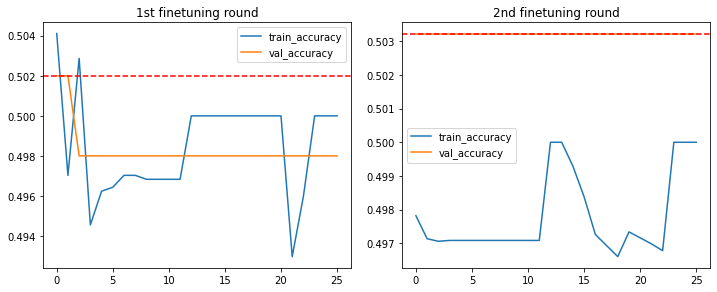

In [4]:
%pylab inline

def show_train_result(train_result=None, ax=None, title=None):
    df = pd.DataFrame({
        'train_loss': train_result['train.score']['loss'],
        'val_loss': train_result['val.score']['loss'],
        'train_accuracy': train_result['train.score']['accuracy'],
        'val_accuracy': train_result['val.score']['accuracy']
    })

    ax = df.loc[:, ['train_accuracy', 'val_accuracy']].plot(ax=ax, title=title, label='best:0.999')
    bs = train_result['best_score']
    ax.axhline(y=bs, ls='--', c='red')
#     ax.annotate('%0.2f' % bs, (10, bs+0.01))
    print('##############################')
    print('n_epochs: %s' % train_result['n_epochs'])
    print('stopped_epoch: %s' % train_result['stopped_epoch'])
    print('best_epoch: %s' % train_result['best_epoch'])
    print('best_score: %s' % train_result['best_score'])
    print('best_chk: %s' % train_result['best_chk'])


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.tight_layout(h_pad=2, w_pad=2)

show_train_result(train_result=experiment.get_train_result(0), 
                  ax=axes[0], 
                  title='1st finetuning round')
show_train_result(train_result=experiment.get_train_result(1), 
                  ax=axes[1], 
                  title='2nd finetuning round')



## Loading final fine-tuned model

In [29]:
model = experiment.load_eval_model()
display(model)

# Eval result recoder
eval_recoder = PredResultRecoder(output_attentions=True)
model.add_pred_listener(eval_recoder)

2021-09-28 00:26:21 [INFO]: Create TAPE model using config: ../config/bert-base/
2021-09-28 00:26:23 [INFO]: Loading the eval model from ../output/exp1/train.1.model_23.chk


BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.1)
            )
     

## 모델 평가와 결과분석

### Shomuradova et al

- Performance evaluation for the dataset containing COVID-19 S-protein269-277(YLQPRTFLL) epitope with the 352 epitope-specific TCRβs from {Shomuradova:2020}
- TCR3b sequence motifs와 attention weights와의 상관관계는?

In [45]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset

epitope = 'YLQPRTFLL'
metrics = ['accuracy', 'f1', 'roc_auc']

eval_ds = TCREpitopeSentenceDataset.from_key('shomuradova')
eval_data_loader = DataLoader(eval_ds, batch_size=len(eval_ds), shuffle=False, num_workers=2)

model.predict(data_loader=eval_data_loader, metrics=metrics)

2021-09-28 02:04:48 [INFO]: ======================
2021-09-28 02:04:48 [INFO]: Begin predict...
2021-09-28 02:04:48 [INFO]: use_cuda, device: False, cpu
2021-09-28 02:04:48 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBe

2021-09-28 02:04:48 [INFO]: n_data: 610
2021-09-28 02:04:48 [INFO]: batch_size: 610
2021-09-28 02:04:48 [INFO]: Begin 0/1 prediction batch
2021-09-28 02:04:58 [INFO]: End 0/1 prediction batch
2021-09-28 02:04:58 [INFO]: Done to predict...
2021-09-28 02:04:58 [INFO]: ======================


### ROC performance curve

Populating the interactive namespace from numpy and matplotlib
score_map: OrderedDict([('accuracy', 0.9573770491803278), ('f1', 0.9568106312292358), ('roc_auc', 0.9826390755173341)])


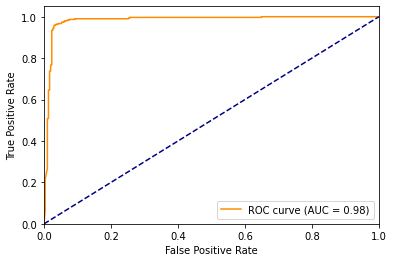

In [52]:
%pylab inline

from sklearn.metrics import roc_curve, auc

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

### Length distributions of CDR3beta sequences

- Model에 의해 Positive/Negative로 분류된 CDR3beta 서열의 길이 분포를 알아본다

Populating the interactive namespace from numpy and matplotlib
Write fasta for pos_cdr3b seqs.
Write fasta for neg_cdr3b seqs.


Text(0.5, 24.0, 'Length')

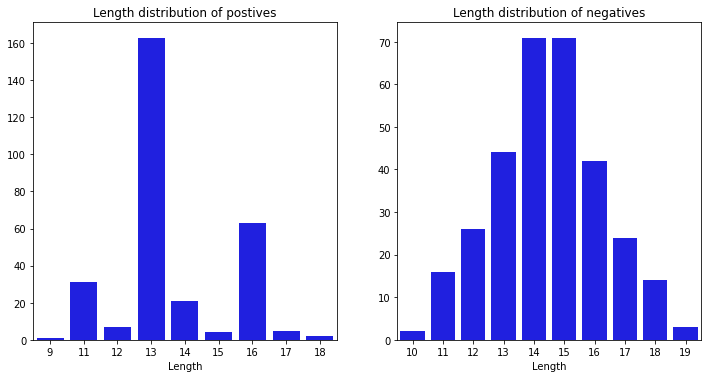

In [57]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

eval_df = eval_ds.df_enc

pos_indices = np.where(output_labels == 1)[0]
neg_indices = np.where(output_labels == 0)[0]

# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
# print('neg_indices: %s(%s)' % (neg_indices, str(neg_indices.shape)))

pos_cdr3b = eval_df[CN.cdr3b].values[pos_indices]
neg_cdr3b = eval_df[CN.cdr3b].values[neg_indices]

write_fa('../output/shomuradova.pos_cdr3b.fa', pos_cdr3b)
print('Write fasta for pos_cdr3b seqs.')

write_fa('../output/shomuradova.neg_cdr3b.fa', neg_cdr3b)
print('Write fasta for neg_cdr3b seqs.')

##########################################
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(h_pad=1, w_pad=3)

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[0], color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), neg_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[1], color='blue')
ax.set_title('Length distribution of negatives')
ax.set_xlabel('Length')

# pos_slogo = image.imread('../output/shomuradova.pos_cdr3b_seqlogo.jpeg')
# axes[1][0].set_title('SeqLogo for positive MSA')
# axes[1][0].set_axis_off()
# axes[1][0].imshow(pos_slogo, aspect='equal')

# neg_slogo = image.imread('../output/shomuradova.neg_cdr3b_seqlogo.jpeg')
# axes[1][1].set_title('SeqLogo for negative MSA')
# axes[1][1].set_axis_off()
# axes[1][1].imshow(neg_slogo, aspect='equal')

- Length distribution
    - Positive의 경우, 대부분의 서열 길이는 13이고 뒤를 이어 16, 11에 몰려 있다
    - Negative의 경우, 11-18 길이로 골고루 분포되어 있으며, 14, 15에 가장 많이 있다.  

<strike>
- MSA
    - Positive의 경우, 1-3번 위치에 C, A, <b>8번 위치에 P</b>, 16-20번 위치에 E, F가 모티프
    - Negative의 경우, 1-3번 위치에 C, A, 4, 5번 위치에 S, 18-21번 위치에 각각 E, Q, F, 22-25번에 P, Q, H, F가 모티프

- Positive/negative MSA 간의 모티프 차이점
    - 앞단 위치의 모티프 구성: pos=>CCA, neg=>CCASS
    - Positive MSA의 8번 위치의 P
    - 말단 위치에서의 positive의 경우 E, F로 모티프가 구성되는 반면, negative의 경우 E, Q, F로 구성되는 점
    - Positive MSA에서는 나타나지 않은 negative의 최말단에 P, Q, H, F로 구성되는 모티프가 있음
</strike>

### Investigation of attention weights in YLQPRTFLL-CDR3b sequences 
- Epitope-specific TCR 상호작용에서의 위치 특이적 모티프들을 알아내기 위해 보통 TCR 서열들의 MSA 상에서 highly-conserved 위치들을 모티프로 본다. 

- YLQPRTFLL 에피토프와 TCR 상호작용에서의 위치특이적 아미노산 기여도를 알아내기 위해서 positive 데이터셋의 epitope-CDR3beta 서열 상에서 우리의 모델에 의해 캡쳐되는 attention weight를 조사하였다.
- BERTology는 TAPE, ProtAlbert 등과 같은 protein Transformer 모델의 output attention을 분석을 통하여 단백질 접힘 구조와 단백질 목표 결합 사이트 등을 효과적으로 캡쳐할 수 있음을 보였다{Vig, J:2020}
- Epitope-specific TCR 인지에서의 기존의 서열 기반의 모티프 분석 방법들은 TCR 서열들만을 대상으로 highly conserved 위치들을 대상으로 하기 때문에 epitope 펩타이드 서열 상의 모티프를 식별하는 것은 어려웠다. 
- 그러나, 여기서 제시하고 있는 방법은 epitope 펩타이드 서열과 TCR 서열 모두 동시에 고려하기 때문에 더욱 유용하다. 

Transformer architectures have proven to learn useful representations for protein classification and generation tasks. However, these representations present challenges in interpretability. In this work, we demonstrate a set of methods for analyzing protein Transformer models through the lens of attention. We show that attention: (1) captures the folding structure of proteins, connecting amino acids that are far apart in the underlying sequence, but spatially close in the three-dimensional structure, (2) targets binding sites, a key functional component of proteins, and (3) focuses on progressively more complex biophysical properties with increasing layer depth. We find this behavior to be consistent across three Transformer architectures (BERT, ALBERT, XLNet) and two distinct protein datasets. We also present a three-dimensional visualization of the interaction between attention and protein structure. Code for visualization and analysis is available at this https URL.

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 610, 12, 40, 40)
pos_attns.shape: (12, 297, 12, 40, 40), neg_attns.shape: (12, 313, 12, 40, 40)
sub_pos_attns.shape: (6, 28), sub_neg_attns.shape: (6, 29)


<AxesSubplot:xlabel='Position', ylabel='Layer'>

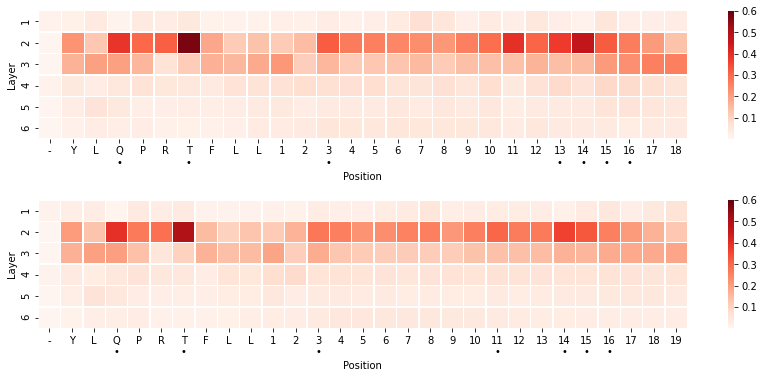

In [73]:
%pylab inline

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

def show_attentions(attns=None, ax=None, mark_top_rank=None):
    g = sns.heatmap(attns, ax=ax, linewidths=.4, cmap='Reds', vmax=0.6, cbar=True)
    g.set_xlabel('Position')
    xt_labels = ['-'] + list(epitope) + \
                list(range(1, attns.shape[1] - len(epitope)))
    
    if mark_top_rank:
        for rank, pos in enumerate(np.argsort(attns.mean(axis=0))[::-1]):
            if rank < mark_top_rank:
                xt_labels[pos] = '%s\n•' % (xt_labels[pos])
            
    g.set_xticklabels(xt_labels)    
    g.set_ylabel('Layer')
    g.set_yticklabels(range(1, attns.shape[0] + 1))
    return g

n_layers = model.config.num_hidden_layers
n_data = len(eval_ds)
n_heads = model.config.num_attention_heads
max_len = eval_ds.max_len

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

pos_attns = attentions[:, pos_indices]
neg_attns = attentions[:, neg_indices]
print('pos_attns.shape: %s, neg_attns.shape: %s' % (str(pos_attns.shape), str(neg_attns.shape)))

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(12)
fig.set_figheight(5)
plt.tight_layout(h_pad=4)

max_pos = 1 + len(epitope) + max(map(lambda x: len(x), pos_cdr3b))
sub_pos_attns = np.median(pos_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))
max_pos = 1 + len(epitope) + max(map(lambda x: len(x), neg_cdr3b))
sub_neg_attns = np.median(neg_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))

print('sub_pos_attns.shape: %s, sub_neg_attns.shape: %s' % (str(sub_pos_attns.shape), str(sub_neg_attns.shape)))
show_attentions(attns=sub_pos_attns, ax=axes[0], mark_top_rank=7)
show_attentions(attns=sub_neg_attns, ax=axes[1], mark_top_rank=7)


#### Results
- YLQPRTFLL 에피토프의 4번 위치의 P에 매우 높은 attention 가중치가 나왔다. 이는 TCR-epitope 상호작용에 있어 4번 위치의 P가 매우 중요한 역할을 한다는 것을 보여 준다.
- 2021.6월에 medRxiv preprint로 공개된 {Garry Dolton:2021}에 따르면 spike protein에서의 P272L 변이는 영국의 2차 대유행과 연관이 있음이 밝혀졌다. P272L 변이는 완치된 환자의 T-Cell 대응을 무력화 시키고, 따라서 기존 COVID-19 백신으로 T-Cell 면역이 활성화된 대조군에서 P272L 변이 펩타이드를 인지하지 못하는 것으로 밝혀졌다(https://www.news-medical.net/news/20210629/Widespread-SARS-CoV-2-mutation-escapes-vaccine-and-infection-induced-CD8-T-cell-responses.aspx).
- 자 그럼, P4와 높은 상호작용을 하는 TCR 서열의 잔기 위치는 어디일까? 이는 TCR 서열 위치에서의 attention 가중치가 높은 위치일 것이다. 
- TCR 서열에서 Attention weight가 상대적으로 높은 곳은 1, 8, 14, 15, 17, 18번이다. 이는 MSA seqlogo에서 보는 바와 같이 Gap을 고려하지 않는다면 대부분 highly conserved된 모티프 부위와 거의 일치한다.
- 특히, negative MSA와 극명하게 차이나는 모티프인 8번 위치는 높은 attention weight를 보이는 것으로 나타났다.


## ImmuneCODE

-  The dataset contained 415 COVID-19 S-protein269-277-specific TCRs from the ImmuneRACE study launched by Adaptive Biotechnologies and Microsoft (https://immunerace.adaptivebiotech.com, June 10, 2020 dataset, from hereon referred to as ImmuneCODE dataset
- TCR3b sequence motifs와 attention weights와의 상관관계는?

In [74]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset

eval_ds = TCREpitopeSentenceDataset.from_key('immunecode')
eval_data_loader = DataLoader(eval_ds, batch_size=len(eval_ds), shuffle=False, num_workers=2)

model.predict(data_loader=eval_data_loader, metrics=metrics)

2021-09-28 03:41:01 [INFO]: ======================
2021-09-28 03:41:01 [INFO]: Begin predict...
2021-09-28 03:41:01 [INFO]: use_cuda, device: False, cpu
2021-09-28 03:41:01 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBe

2021-09-28 03:41:01 [INFO]: n_data: 765
2021-09-28 03:41:01 [INFO]: batch_size: 765
2021-09-28 03:41:01 [INFO]: Begin 0/1 prediction batch
2021-09-28 03:41:32 [INFO]: End 0/1 prediction batch
2021-09-28 03:41:33 [INFO]: Done to predict...
2021-09-28 03:41:33 [INFO]: ======================


### ROC performance curve

Populating the interactive namespace from numpy and matplotlib
score_map: OrderedDict([('accuracy', 0.9633986928104575), ('f1', 0.9622641509433962), ('roc_auc', 0.9859417808219179)])


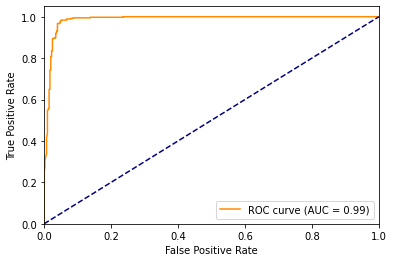

In [75]:
%pylab inline

from sklearn.metrics import roc_curve, auc

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

### Length distributions of TCR CDR3b sequences

Populating the interactive namespace from numpy and matplotlib
Write fasta for pos_cdr3b seqs.
Write fasta for neg_cdr3b seqs.


Text(0.5, 24.0, 'Length')

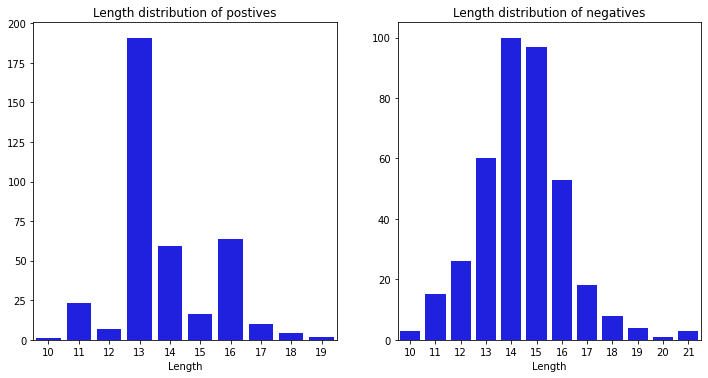

In [76]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

eval_df = eval_ds.df_enc

pos_indices = np.where(output_labels == 1)[0]
neg_indices = np.where(output_labels == 0)[0]

# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
# print('neg_indices: %s(%s)' % (neg_indices, str(neg_indices.shape)))

pos_cdr3b = eval_df[CN.cdr3b].values[pos_indices]
neg_cdr3b = eval_df[CN.cdr3b].values[neg_indices]

write_fa('../output/immunecode.pos_cdr3b.fa', pos_cdr3b)
print('Write fasta for pos_cdr3b seqs.')

write_fa('../output/immunecode.neg_cdr3b.fa', neg_cdr3b)
print('Write fasta for neg_cdr3b seqs.')

##########################################
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(h_pad=1, w_pad=3)

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[0], color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), neg_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[1], color='blue')
ax.set_title('Length distribution of negatives')
ax.set_xlabel('Length')

### Investigation of attention weights

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 765, 12, 40, 40)
pos_attns.shape: (12, 377, 12, 40, 40), neg_attns.shape: (12, 388, 12, 40, 40)
sub_pos_attns.shape: (6, 29), sub_neg_attns.shape: (6, 31)


<AxesSubplot:xlabel='Position', ylabel='Layer'>

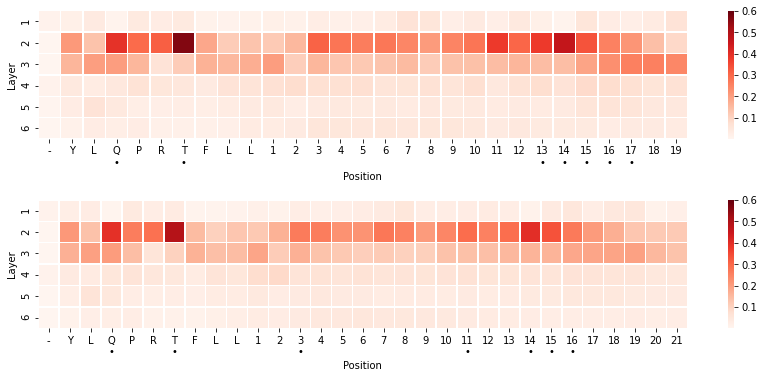

In [87]:
%pylab inline

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

n_layers = model.config.num_hidden_layers
n_data = len(eval_ds)
n_heads = model.config.num_attention_heads
max_len = eval_ds.max_len

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

pos_attns = attentions[:, pos_indices]
neg_attns = attentions[:, neg_indices]


print('pos_attns.shape: %s, neg_attns.shape: %s' % (str(pos_attns.shape), str(neg_attns.shape)))
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(12)
fig.set_figheight(5)
plt.tight_layout(h_pad=4)

max_pos = 1 + len(epitope) + max(map(lambda x: len(x), pos_cdr3b))
sub_pos_attns = np.median(pos_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))
max_pos = 1 + len(epitope) + max(map(lambda x: len(x), neg_cdr3b))
sub_neg_attns = np.median(neg_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))

print('sub_pos_attns.shape: %s, sub_neg_attns.shape: %s' % (str(sub_pos_attns.shape), str(sub_neg_attns.shape)))


show_attentions(attns=sub_pos_attns, ax=axes[0], mark_top_rank=7)
show_attentions(attns=sub_neg_attns, ax=axes[1], mark_top_rank=7)


- Shomuradova 데이터셋의 결과와 마찬가지로, YLQPRTFLL 에피토프의 4번 위치의 P에 매우 높은 attention 가중치가 나왔다. 이는 TCR 분자가 에피토프를 인지하여 T-Cell 면역 대응을 유도하는 데 있어 에피토프의 4번 위치의 P가 매우 중요한 역할을 한다는 것을 보여 준다.
- 몇달전에 {Garry Dolton:2021} 연구에서 보고된 바에 따르면 spike protein에서의 P272L 변이는 영국의 2차 대유행과 연관이 있음이 밝혀졌다. P272L 변이는 완치된 환자의 T-Cell 대응을 무력화 시키고 백신에 대한 면역 회피를 야기하는 것으로 알려졌다.
- 자 그럼, 에피토와와 높은 상호작용을 하는 TCR 서열의 잔기 위치는 어디일까? 이는 TCR 서열 위치에서의 attention 가중치가 높은 위치일 것이다. 
- TCR 서열에서 Attention weight가 상대적으로 높은 곳은 Shomuradova 데이터셋의 결과와 마찬가지로 1, 8, 14, 15, 17, 18번이다. 이는 MSA seqlogo에서 보는 바와 같이 Gap을 고려하지 않는다면 대부분 highly conserved된 모티프 부위와 어느 정도 일치하지만 Shomuradova 데이터셋만큼은 아니다. 
- 이것으로 볼때, 에피토프와 높은 상호작용을 하는 TCR 서열 잔기 위치를 파악하는 데 있어 MSA 기반으로 conserved 모티프로부터 추론하는 방법도 전통적으로 유용하지만 attention weight로부터 유추하는 것이 더욱 심플하고 효과적일 수 있다는 것을 알 수 있다.